## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from prophet import Prophet
import pandas as pd
import aux_functions_ml as f

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [126]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
#import pmdarima
#from pmdarima import ARIMA
#from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
#print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.14.0
Versión statsmodels: 0.14.4
Versión pandas: 2.2.3
Versión numpy: 2.1.3


## Load data

In [2]:
df_orders_details = pd.read_csv("../Datasets/clean_order_details.csv", index_col=0)
df_orders = pd.read_csv("../Datasets/clean_orders.csv", index_col=0)
df_products = pd.read_csv("../Datasets/clean_products.csv", index_col=0)

In [3]:
df_orders

OrderID  CustomerID  EmployeeID  ShippingMethodID   OrderDate  \
0           2           1           1                 1  2003-07-10   
1           4           2           2                 1  2003-07-11   
2           5           2           1                 1  2003-07-15   
3           6           3           1                 1  2003-07-14   
4           7           4           1                 1  2003-07-14   
...       ...         ...         ...               ...         ...   
2281     2466          40           8                 1  2006-04-14   
2282     2467           7           8                 1  2006-04-14   
2283     2468          82           8                 1  2006-04-18   
2284     2469         231           8                 1  2006-04-19   
2285     2470         231           8                 1  2006-04-20   

        ShipDate  FreightCharge  DeliveryTime  OrderYear  OrderMonth  
0     2003-07-10            0.0             0       2003           7  
1     2003-07-11            0.0             0       2003           7  
2     2003-07-15            0.0             0       2003           7  
3     2003-07-14            0.0             0       2003           7  
4     2003-07-15            0.0             1       2003           7  
...          ...            ...           ...        ...         ...  
2281  2006-04-14            0.0             0       2006           4  
2282  2006-04-14            0.0             0       2006           4  
2283  2006-04-18           31.0             0       2006           4  
2284  2006-04-19            0.0             0       2006           4  
2285  2006-04-20            0.0             0       2006           4  

[2278 rows x 10 columns]

In [4]:
df_orders_details

OrderDetailID  OrderID  ProductID  QuantitySold  UnitSalesPrice  \
0                   2        2        955             5             7.5   
1                   3        2        958             5             8.5   
2                   5        2        959             5             8.5   
3                   6        4         72            50             3.0   
4                   7        4          9            50             3.2   
...               ...      ...        ...           ...             ...   
105752         114665     2470       4342            20             1.7   
105753         114666     2470       4419            10             1.9   
105754         114667     2470       4343            20             1.9   
105755         114668     2470       4421            10             2.1   
105756         114669     2470       4344            20             2.0   

        total_price  
0              37.5  
1              42.5  
2              42.5  
3             150.0  
4             160.0  
...             ...  
105752         34.0  
105753         19.0  
105754         38.0  
105755         21.0  
105756         40.0  

[105757 rows x 6 columns]

In [5]:
df_products

ProductID ProductName ModelDescription     Category              Gender  \
0             1       3-182               AT  Undershirts  Girls' Undershirts   
1             2       3-183               AT  Undershirts  Girls' Undershirts   
2             3       3-184               AT  Undershirts  Girls' Undershirts   
3             4       3-185               AT  Undershirts   Boys' Undershirts   
4             5      3-A30N                A       Briefs      Girls' Panties   
...         ...         ...              ...          ...                 ...   
4178       4419    L-BX46CK               BX       Boxers        Men's Briefs   
4179       4420    M-BX46CK               BX       Boxers        Men's Briefs   
4180       4421   XL-BX46CK               BX       Boxers        Men's Briefs   
4181       4422      L-D46D                D       Briefs     Women's Panties   
4182       4423      M-TV46               TV       Thongs     Women's Panties   

     ProductLine  Weight Size     PackSize             Status InventoryDate  \
0      Underwear     822    M        Dozen      In Production    2003-07-10   
1      Underwear     620    M        Dozen  Out of Production    2003-07-10   
2      Underwear     718    M        Dozen      In Production    2003-07-10   
3      Underwear     820    M        Dozen      In Production    2003-07-10   
4      Underwear     214    M        Dozen  Out of Production    2003-08-06   
...          ...     ...  ...          ...                ...           ...   
4178   Underwear      90    L  Single Unit      In Production    2006-04-04   
4179   Underwear      85    M  Single Unit      In Production    2006-04-04   
4180   Underwear     100   XL  Single Unit      In Production    2006-04-04   
4181   Underwear     285    L        Dozen      In Production    2006-04-04   
4182   Underwear     190    M        Dozen      In Production    2006-04-18   

      PurchasePrice ProductType  
0               6.6         182  
1               5.6         183  
2               6.3         184  
3               5.6         185  
4               3.3        A30N  
...             ...         ...  
4178            1.3      BX46CK  
4179            1.2      BX46CK  
4180            1.4      BX46CK  
4181            3.9        D46D  
4182            3.3        TV46  

[4168 rows x 13 columns]

### Merge data

In [6]:
df = df_orders.merge(df_orders_details, on = "OrderID")
df

OrderID  CustomerID  EmployeeID  ShippingMethodID   OrderDate  \
0             2           1           1                 1  2003-07-10   
1             2           1           1                 1  2003-07-10   
2             2           1           1                 1  2003-07-10   
3             2           1           1                 1  2003-07-10   
4             2           1           1                 1  2003-07-10   
...         ...         ...         ...               ...         ...   
105265     2470         231           8                 1  2006-04-20   
105266     2470         231           8                 1  2006-04-20   
105267     2470         231           8                 1  2006-04-20   
105268     2470         231           8                 1  2006-04-20   
105269     2470         231           8                 1  2006-04-20   

          ShipDate  FreightCharge  DeliveryTime  OrderYear  OrderMonth  \
0       2003-07-10            0.0             0       2003           7   
1       2003-07-10            0.0             0       2003           7   
2       2003-07-10            0.0             0       2003           7   
3       2003-07-10            0.0             0       2003           7   
4       2003-07-10            0.0             0       2003           7   
...            ...            ...           ...        ...         ...   
105265  2006-04-20            0.0             0       2006           4   
105266  2006-04-20            0.0             0       2006           4   
105267  2006-04-20            0.0             0       2006           4   
105268  2006-04-20            0.0             0       2006           4   
105269  2006-04-20            0.0             0       2006           4   

        OrderDetailID  ProductID  QuantitySold  UnitSalesPrice  total_price  
0                   2        955             5             7.5         37.5  
1                   3        958             5             8.5         42.5  
2                   5        959             5             8.5         42.5  
3                   8        715            30             4.7        141.0  
4                   9        421            10             5.1         51.0  
...               ...        ...           ...             ...          ...  
105265         114665       4342            20             1.7         34.0  
105266         114666       4419            10             1.9         19.0  
105267         114667       4343            20             1.9         38.0  
105268         114668       4421            10             2.1         21.0  
105269         114669       4344            20             2.0         40.0  

[105270 rows x 15 columns]

In [7]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.dtypes

OrderID                      int64
CustomerID                   int64
EmployeeID                   int64
ShippingMethodID             int64
OrderDate           datetime64[ns]
ShipDate                    object
FreightCharge              float64
DeliveryTime                 int64
OrderYear                    int64
OrderMonth                   int64
OrderDetailID                int64
ProductID                    int64
QuantitySold                 int64
UnitSalesPrice             float64
total_price                float64
dtype: object

In [8]:
df

OrderID  CustomerID  EmployeeID  ShippingMethodID  OrderDate  \
0             2           1           1                 1 2003-07-10   
1             2           1           1                 1 2003-07-10   
2             2           1           1                 1 2003-07-10   
3             2           1           1                 1 2003-07-10   
4             2           1           1                 1 2003-07-10   
...         ...         ...         ...               ...        ...   
105265     2470         231           8                 1 2006-04-20   
105266     2470         231           8                 1 2006-04-20   
105267     2470         231           8                 1 2006-04-20   
105268     2470         231           8                 1 2006-04-20   
105269     2470         231           8                 1 2006-04-20   

          ShipDate  FreightCharge  DeliveryTime  OrderYear  OrderMonth  \
0       2003-07-10            0.0             0       2003           7   
1       2003-07-10            0.0             0       2003           7   
2       2003-07-10            0.0             0       2003           7   
3       2003-07-10            0.0             0       2003           7   
4       2003-07-10            0.0             0       2003           7   
...            ...            ...           ...        ...         ...   
105265  2006-04-20            0.0             0       2006           4   
105266  2006-04-20            0.0             0       2006           4   
105267  2006-04-20            0.0             0       2006           4   
105268  2006-04-20            0.0             0       2006           4   
105269  2006-04-20            0.0             0       2006           4   

        OrderDetailID  ProductID  QuantitySold  UnitSalesPrice  total_price  
0                   2        955             5             7.5         37.5  
1                   3        958             5             8.5         42.5  
2                   5        959             5             8.5         42.5  
3                   8        715            30             4.7        141.0  
4                   9        421            10             5.1         51.0  
...               ...        ...           ...             ...          ...  
105265         114665       4342            20             1.7         34.0  
105266         114666       4419            10             1.9         19.0  
105267         114667       4343            20             1.9         38.0  
105268         114668       4421            10             2.1         21.0  
105269         114669       4344            20             2.0         40.0  

[105270 rows x 15 columns]

### Group sales by product

**ABC Classification**

The ABC criterion is based on the contribution of each product to total revenues:

- Class A: Represent 60% of revenues.
- Class B: Represent 30% of revenues.
- Class C: Represent the remaining 10%.

In [9]:
total_sales = df.groupby('ProductID')['total_price'].sum().reset_index()

total_sales = total_sales.sort_values(by='total_price', ascending=False)

total_sales

ProductID  total_price
391         427      34465.0
170         183      31866.1
866         932      28693.7
792         856      28052.7
923         989      25377.5
...         ...          ...
359         387          1.2
615         675          1.1
3946       4300          1.0
1959       2088          0.0
2433       2640          0.0

[4041 rows x 2 columns]

In [10]:
total_sales['Accumulative Percentage'] = total_sales['total_price'].cumsum() / total_sales['total_price'].sum()
total_sales

ProductID  total_price  Accumulative Percentage
391         427      34465.0                 0.008749
170         183      31866.1                 0.016838
866         932      28693.7                 0.024121
792         856      28052.7                 0.031242
923         989      25377.5                 0.037684
...         ...          ...                      ...
359         387          1.2                 0.999999
615         675          1.1                 1.000000
3946       4300          1.0                 1.000000
1959       2088          0.0                 1.000000
2433       2640          0.0                 1.000000

[4041 rows x 3 columns]

In [11]:
total_sales['Classification'] = total_sales['Accumulative Percentage'].apply(f.abc_classification)

In [12]:
total_sales

ProductID  total_price  Accumulative Percentage Classification
391         427      34465.0                 0.008749              A
170         183      31866.1                 0.016838              A
866         932      28693.7                 0.024121              A
792         856      28052.7                 0.031242              A
923         989      25377.5                 0.037684              A
...         ...          ...                      ...            ...
359         387          1.2                 0.999999              C
615         675          1.1                 1.000000              C
3946       4300          1.0                 1.000000              C
1959       2088          0.0                 1.000000              C
2433       2640          0.0                 1.000000              C

[4041 rows x 4 columns]

In [13]:
total_sales['Classification'].value_counts()

Classification
C    2167
B    1425
A     449
Name: count, dtype: int64

#### **Categorise according to their demand**

Now that we have the ABC classification, we will categorise the products according to their demand: **high or low**. 

Products with less than 10 units (*median*) of monthly demand or with more than 30% of months without sales will be classified as low demand.


In [14]:
df

OrderID  CustomerID  EmployeeID  ShippingMethodID  OrderDate  \
0             2           1           1                 1 2003-07-10   
1             2           1           1                 1 2003-07-10   
2             2           1           1                 1 2003-07-10   
3             2           1           1                 1 2003-07-10   
4             2           1           1                 1 2003-07-10   
...         ...         ...         ...               ...        ...   
105265     2470         231           8                 1 2006-04-20   
105266     2470         231           8                 1 2006-04-20   
105267     2470         231           8                 1 2006-04-20   
105268     2470         231           8                 1 2006-04-20   
105269     2470         231           8                 1 2006-04-20   

          ShipDate  FreightCharge  DeliveryTime  OrderYear  OrderMonth  \
0       2003-07-10            0.0             0       2003           7   
1       2003-07-10            0.0             0       2003           7   
2       2003-07-10            0.0             0       2003           7   
3       2003-07-10            0.0             0       2003           7   
4       2003-07-10            0.0             0       2003           7   
...            ...            ...           ...        ...         ...   
105265  2006-04-20            0.0             0       2006           4   
105266  2006-04-20            0.0             0       2006           4   
105267  2006-04-20            0.0             0       2006           4   
105268  2006-04-20            0.0             0       2006           4   
105269  2006-04-20            0.0             0       2006           4   

        OrderDetailID  ProductID  QuantitySold  UnitSalesPrice  total_price  
0                   2        955             5             7.5         37.5  
1                   3        958             5             8.5         42.5  
2                   5        959             5             8.5         42.5  
3                   8        715            30             4.7        141.0  
4                   9        421            10             5.1         51.0  
...               ...        ...           ...             ...          ...  
105265         114665       4342            20             1.7         34.0  
105266         114666       4419            10             1.9         19.0  
105267         114667       4343            20             1.9         38.0  
105268         114668       4421            10             2.1         21.0  
105269         114669       4344            20             2.0         40.0  

[105270 rows x 15 columns]

In [15]:
df['YearMonth'] = df['OrderDate'].dt.to_period('M')
df['YearMonth']

0         2003-07
1         2003-07
2         2003-07
3         2003-07
4         2003-07
           ...   
105265    2006-04
105266    2006-04
105267    2006-04
105268    2006-04
105269    2006-04
Name: YearMonth, Length: 105270, dtype: period[M]

In [16]:
df['YearMonth'].nunique(), df['YearMonth'].nunique()*0.3

(34, 10.2)

In [17]:
monthly_sales = df.groupby(['ProductID', 'YearMonth'])['QuantitySold'].sum().reset_index()
monthly_sales

ProductID YearMonth  QuantitySold
0              1   2003-08             5
1              1   2003-12             2
2              1   2004-01             4
3              1   2004-02            13
4              1   2004-03             5
...          ...       ...           ...
34676       4419   2006-04            10
34677       4420   2006-04            10
34678       4421   2006-04            10
34679       4422   2006-04             5
34680       4423   2006-04             5

[34681 rows x 3 columns]

In [18]:
#convert yearmonth to string 
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)
monthly_sales.dtypes

ProductID        int64
YearMonth       object
QuantitySold     int64
dtype: object

1. Calculate the average demand by product

In [19]:
average_demand = monthly_sales.groupby('ProductID')['QuantitySold'].mean().reset_index()
average_demand = average_demand.rename(columns={'QuantitySold': 'AverageDemand'})
average_demand

ProductID  AverageDemand
0             1       5.583333
1             2       6.700000
2             3       8.925926
3             4      15.968750
4             5      29.714286
...         ...            ...
4036       4419      10.000000
4037       4420      10.000000
4038       4421      10.000000
4039       4422       5.000000
4040       4423       5.000000

[4041 rows x 2 columns]

<Axes: >

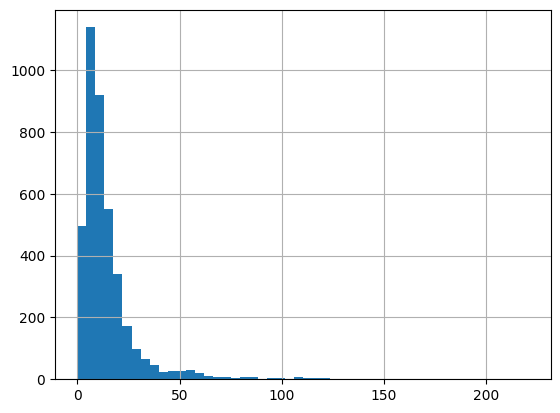

In [20]:
average_demand['AverageDemand'].hist(bins=50)

<Axes: ylabel='AverageDemand'>

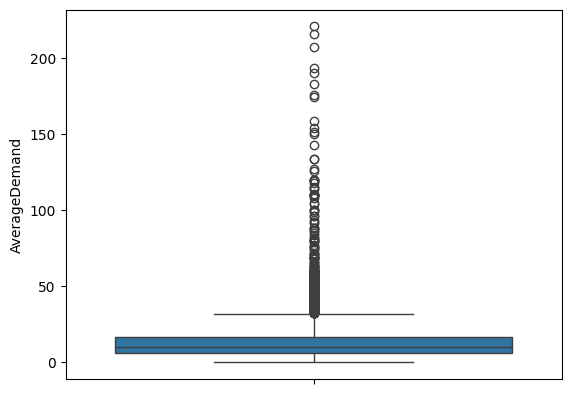

In [21]:
sns.boxplot(average_demand['AverageDemand'])

In [22]:
average_demand['AverageDemand'].mean(), average_demand['AverageDemand'].median()

(np.float64(14.84927265678148), np.float64(10.0))

2. Calculate the month percentage without sales

In [23]:
monthly_sales

ProductID YearMonth  QuantitySold
0              1   2003-08             5
1              1   2003-12             2
2              1   2004-01             4
3              1   2004-02            13
4              1   2004-03             5
...          ...       ...           ...
34676       4419   2006-04            10
34677       4420   2006-04            10
34678       4421   2006-04            10
34679       4422   2006-04             5
34680       4423   2006-04             5

[34681 rows x 3 columns]

In [24]:
null_percentage = monthly_sales.groupby('ProductID').apply(lambda x: (x['QuantitySold'] == 0).mean()).reset_index()
null_percentage = null_percentage.rename(columns={0: 'NullPercentage'})
null_percentage

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13604\3371587230.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_percentage = monthly_sales.groupby('ProductID').apply(lambda x: (x['QuantitySold'] == 0).mean()).reset_index()


ProductID  NullPercentage
0             1        0.000000
1             2        0.050000
2             3        0.037037
3             4        0.031250
4             5        0.000000
...         ...             ...
4036       4419        0.000000
4037       4420        0.000000
4038       4421        0.000000
4039       4422        0.000000
4040       4423        0.000000

[4041 rows x 2 columns]

<Axes: >

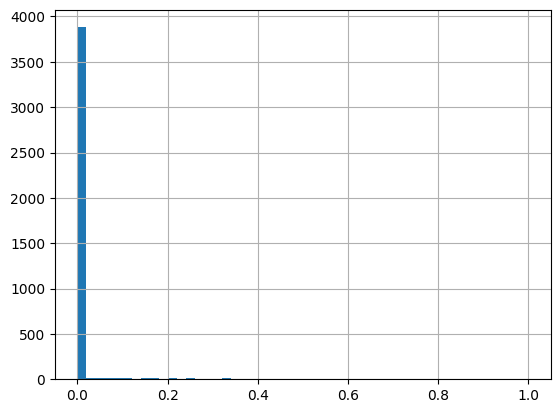

In [25]:
null_percentage['NullPercentage'].hist(bins=50)

<Axes: ylabel='NullPercentage'>

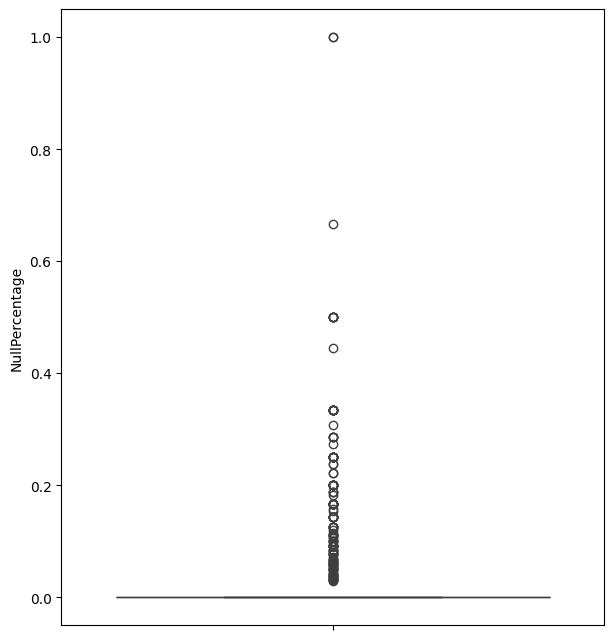

In [26]:
plt.figure(figsize=(7,8))
sns.boxplot(null_percentage['NullPercentage'])

In [27]:
# join both tables

demand_product = pd.merge(average_demand, null_percentage, on='ProductID')
demand_product

ProductID  AverageDemand  NullPercentage
0             1       5.583333        0.000000
1             2       6.700000        0.050000
2             3       8.925926        0.037037
3             4      15.968750        0.031250
4             5      29.714286        0.000000
...         ...            ...             ...
4036       4419      10.000000        0.000000
4037       4420      10.000000        0.000000
4038       4421      10.000000        0.000000
4039       4422       5.000000        0.000000
4040       4423       5.000000        0.000000

[4041 rows x 3 columns]

In [29]:
demand_product['DemandClass'] = demand_product.apply(f.demand_classification, axis=1)
demand_product

ProductID  AverageDemand  NullPercentage  DemandClass
0             1       5.583333        0.000000   Low demand
1             2       6.700000        0.050000   Low demand
2             3       8.925926        0.037037   Low demand
3             4      15.968750        0.031250  High demand
4             5      29.714286        0.000000  High demand
...         ...            ...             ...          ...
4036       4419      10.000000        0.000000  High demand
4037       4420      10.000000        0.000000  High demand
4038       4421      10.000000        0.000000  High demand
4039       4422       5.000000        0.000000   Low demand
4040       4423       5.000000        0.000000   Low demand

[4041 rows x 4 columns]

In [30]:
demand_product['DemandClass'].value_counts()

DemandClass
High demand    2193
Low demand     1848
Name: count, dtype: int64

**Join ABC and Demand Classification**

In [31]:
final_products = total_sales.merge(demand_product, on='ProductID')
final_products

ProductID  total_price  Accumulative Percentage Classification  \
0           427      34465.0                 0.008749              A   
1           183      31866.1                 0.016838              A   
2           932      28693.7                 0.024121              A   
3           856      28052.7                 0.031242              A   
4           989      25377.5                 0.037684              A   
...         ...          ...                      ...            ...   
4036        387          1.2                 0.999999              C   
4037        675          1.1                 1.000000              C   
4038       4300          1.0                 1.000000              C   
4039       2088          0.0                 1.000000              C   
4040       2640          0.0                 1.000000              C   

      AverageDemand  NullPercentage  DemandClass  
0        220.794118             0.0  High demand  
1        182.588235             0.0  High demand  
2        158.862069             0.0  High demand  
3        142.500000             0.0  High demand  
4        110.764706             0.0  High demand  
...             ...             ...          ...  
4036       1.000000             0.0   Low demand  
4037       1.000000             0.0   Low demand  
4038       1.000000             0.0   Low demand  
4039       0.000000             1.0   Low demand  
4040       0.000000             1.0   Low demand  

[4041 rows x 7 columns]

### **EDA**

We are going to study the top product of each category in order to understand our dataset

In [33]:
df_p = df_products.merge(final_products, on = 'ProductID')
df_p

ProductID ProductName ModelDescription     Category              Gender  \
0             1       3-182               AT  Undershirts  Girls' Undershirts   
1             2       3-183               AT  Undershirts  Girls' Undershirts   
2             3       3-184               AT  Undershirts  Girls' Undershirts   
3             4       3-185               AT  Undershirts   Boys' Undershirts   
4             5      3-A30N                A       Briefs      Girls' Panties   
...         ...         ...              ...          ...                 ...   
4024       4419    L-BX46CK               BX       Boxers        Men's Briefs   
4025       4420    M-BX46CK               BX       Boxers        Men's Briefs   
4026       4421   XL-BX46CK               BX       Boxers        Men's Briefs   
4027       4422      L-D46D                D       Briefs     Women's Panties   
4028       4423      M-TV46               TV       Thongs     Women's Panties   

     ProductLine  Weight Size     PackSize             Status InventoryDate  \
0      Underwear     822    M        Dozen      In Production    2003-07-10   
1      Underwear     620    M        Dozen  Out of Production    2003-07-10   
2      Underwear     718    M        Dozen      In Production    2003-07-10   
3      Underwear     820    M        Dozen      In Production    2003-07-10   
4      Underwear     214    M        Dozen  Out of Production    2003-08-06   
...          ...     ...  ...          ...                ...           ...   
4024   Underwear      90    L  Single Unit      In Production    2006-04-04   
4025   Underwear      85    M  Single Unit      In Production    2006-04-04   
4026   Underwear     100   XL  Single Unit      In Production    2006-04-04   
4027   Underwear     285    L        Dozen      In Production    2006-04-04   
4028   Underwear     190    M        Dozen      In Production    2006-04-18   

      PurchasePrice ProductType  total_price  Accumulative Percentage  \
0               6.6         182       1369.1                 0.671082   
1               5.6         183       1164.9                 0.700548   
2               6.3         184       2234.2                 0.553677   
3               5.6         185       4206.4                 0.408154   
4               3.3        A30N       2732.1                 0.508467   
...             ...         ...          ...                      ...   
4024            1.3      BX46CK         19.0                 0.999662   
4025            1.2      BX46CK         18.0                 0.999695   
4026            1.4      BX46CK         21.0                 0.999601   
4027            3.9        D46D         26.5                 0.999397   
4028            3.3        TV46         24.0                 0.999512   

     Classification  AverageDemand  NullPercentage  DemandClass  
0                 B       5.583333        0.000000   Low demand  
1                 B       6.700000        0.050000   Low demand  
2                 A       8.925926        0.037037   Low demand  
3                 A      15.968750        0.031250  High demand  
4                 A      29.714286        0.000000  High demand  
...             ...            ...             ...          ...  
4024              C      10.000000        0.000000  High demand  
4025              C      10.000000        0.000000  High demand  
4026              C      10.000000        0.000000  High demand  
4027              C       5.000000        0.000000   Low demand  
4028              C       5.000000        0.000000   Low demand  

[4029 rows x 19 columns]

In [34]:
top_products = df_p.groupby(['Classification', 'DemandClass']).apply(lambda x: x.nlargest(20, 'AverageDemand')).reset_index(drop=True)
top_products

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13604\3839372858.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products = df_p.groupby(['Classification', 'DemandClass']).apply(lambda x: x.nlargest(20, 'AverageDemand')).reset_index(drop=True)


ProductID   ProductName ModelDescription     Category  \
0          427       M-ERK61              ERK       Briefs   
1            9       3-ERK61              ERK       Briefs   
2         2580  XL-EE782814S               EE       Briefs   
3          183       L-ERK61              ERK       Briefs   
4           72       2-ERK61              ERK       Briefs   
..         ...           ...              ...          ...   
106       1892    XL-BX46K3B               BX       Boxers   
107       2827        3-AL24               AL       Briefs   
108       3412        1-AR98               AR       Briefs   
109        643        S-3101             AT3K  Undershirts   
110       1538        L-K404                K       Briefs   

                  Gender ProductLine  Weight Size     PackSize  \
0           Men's Briefs   Underwear     505    M        Dozen   
1           Boys' Briefs   Underwear     325    M        Dozen   
2        Women's Panties   Underwear     375   XL        Dozen   
3           Men's Briefs   Underwear     575    L        Dozen   
4           Boys' Briefs   Underwear     233    S        Dozen   
..                   ...         ...     ...  ...          ...   
106         Men's Briefs   Underwear      91   XL  Single Unit   
107       Girls' Panties   Underwear     245    M        Dozen   
108       Girls' Panties   Underwear     180   XS        Dozen   
109  Women's Undershirts   Underwear      71    S  Single Unit   
110      Women's Panties   Underwear     420    L        Dozen   

                Status InventoryDate  PurchasePrice ProductType  total_price  \
0        In Production    2003-07-10           3.60       ERK61      34465.0   
1        In Production    2003-07-10           2.70       ERK61      22054.0   
2    Out of Production    2005-04-11           5.50   EE782814S       3305.1   
3        In Production    2003-07-10           3.90       ERK61      31866.1   
4        In Production    2003-07-10           2.50       ERK61      18564.5   
..                 ...           ...            ...         ...          ...   
106  Out of Production    2004-08-31           1.25     BX46K3B        126.6   
107      In Production    2005-06-20           3.99        AL24        387.1   
108      In Production    2005-08-25           2.94        AR98        281.9   
109  Out of Production    2003-07-10           0.60        3101         25.8   
110  Out of Production    2004-02-21           3.80        K404        145.3   

     Accumulative Percentage Classification  AverageDemand  NullPercentage  \
0                   0.008749              A     220.794118             0.0   
1                   0.061403              A     193.250000             0.0   
2                   0.458093              A     190.000000             0.0   
3                   0.016838              A     182.588235             0.0   
4                   0.112941              A     174.312500             0.0   
..                       ...            ...            ...             ...   
106                 0.987310              C       9.714286             0.0   
107                 0.903501              C       9.714286             0.0   
108                 0.941227              C       9.714286             0.0   
109                 0.999424              C       9.666667             0.0   
110                 0.983612              C       9.666667             0.0   

     DemandClass  
0    High demand  
1    High demand  
2    High demand  
3    High demand  
4    High demand  
..           ...  
106   Low demand  
107   Low demand  
108   Low demand  
109   Low demand  
110   Low demand  

[111 rows x 19 columns]

##### **Study by Demand Class**

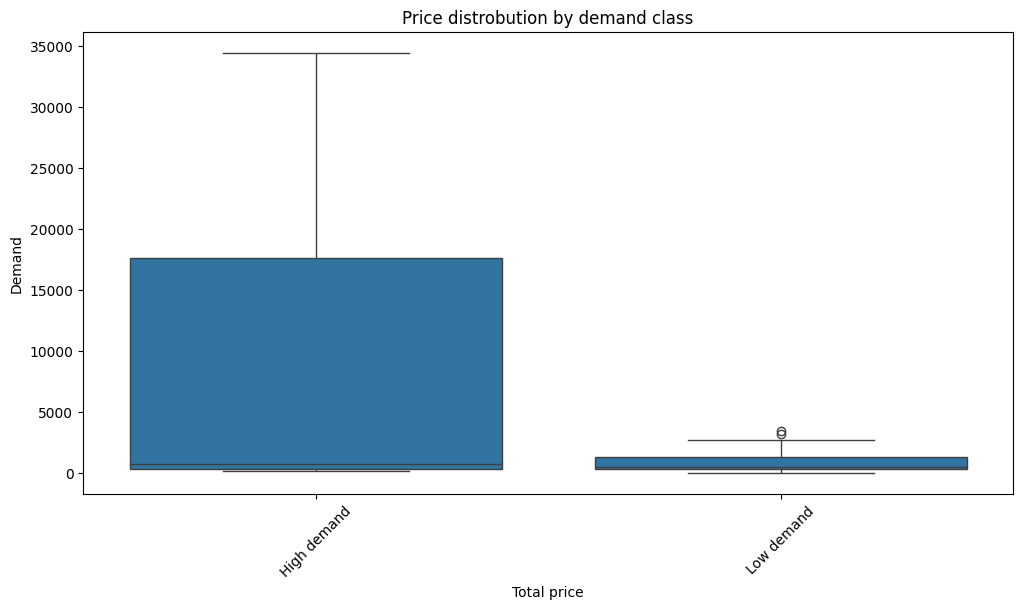

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='DemandClass', y='total_price', data=top_products)
plt.title('Price distrobution by demand class')
plt.xticks(rotation=45)
plt.xlabel('Total price')
plt.ylabel('Demand')
plt.show()

Los productos de alta demanda tienen percios más altos, esto podría indicar que lo productos de alta rotación están valorados más.

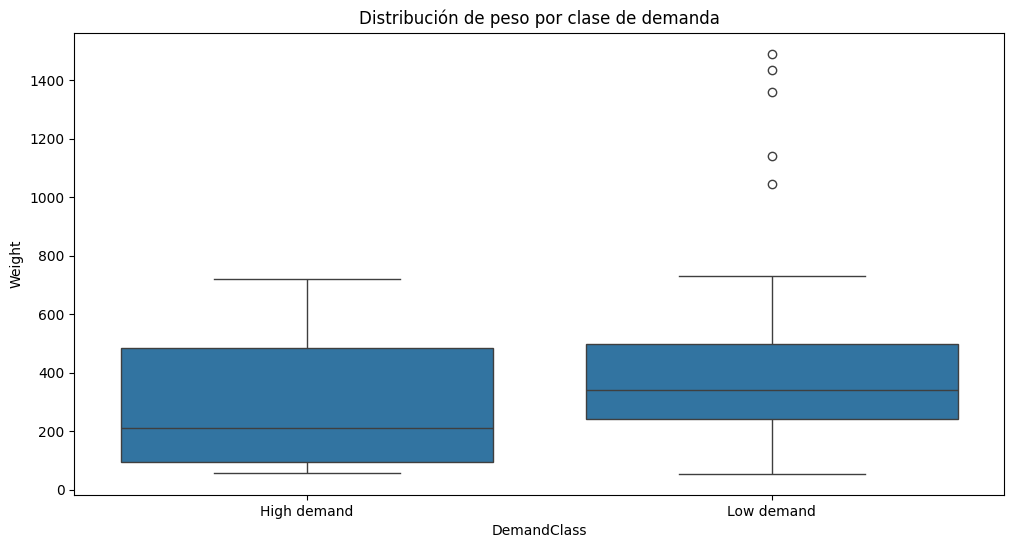

In [39]:
# 2. Promedio de peso y tamaño por clase de demanda
plt.figure(figsize=(12, 6))
sns.boxplot(x='DemandClass', y='Weight', data=top_products)
plt.title('Distribución de peso por clase de demanda')
plt.show()

Los productos de más baja demanda son más pesados en comparación con los de alta demanda. Esto puede indicar que se venden menos al ser más complicado su transporte.

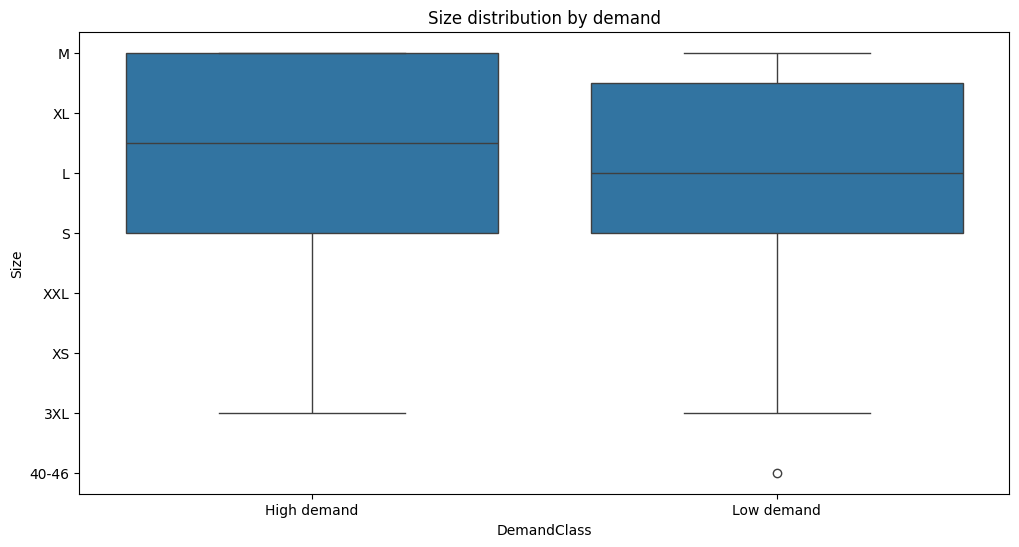

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='DemandClass', y='Size', data=top_products)
plt.title('Size distribution by demand')
plt.show()

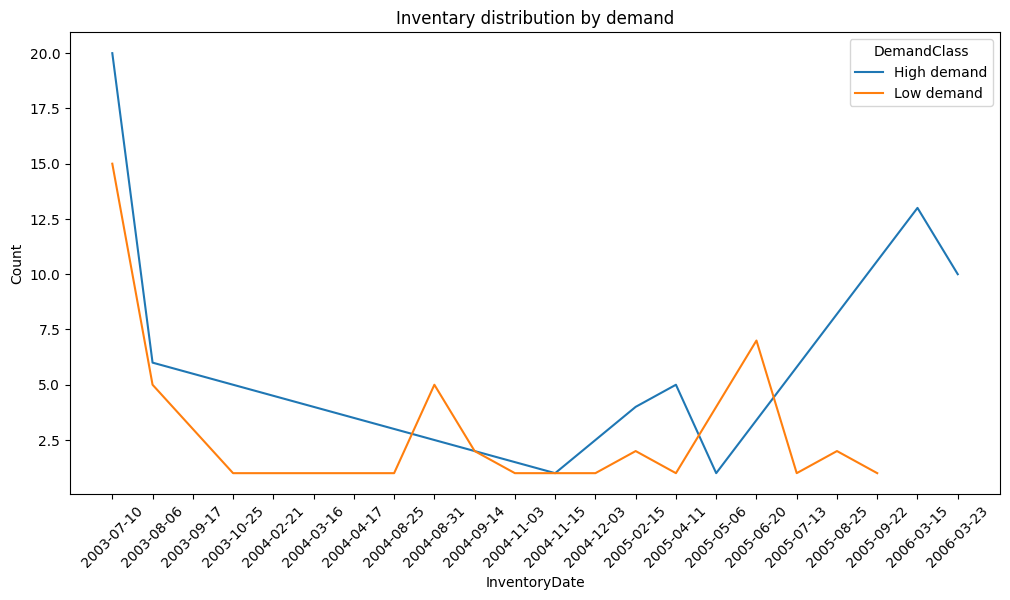

In [47]:
# 4. Distribución del inventario por clase de demanda
df_grouped_demand = top_products.groupby(['InventoryDate', 'DemandClass']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.lineplot(x='InventoryDate', y='Count', hue='DemandClass', data=df_grouped_demand)
plt.title('Inventary distribution by demand')
plt.xticks(rotation=45)
plt.show()

Los productos de baja demanda están asociado con una temporada en particular *Verano*, y en concreto va al contrario que los productos de alta demanda

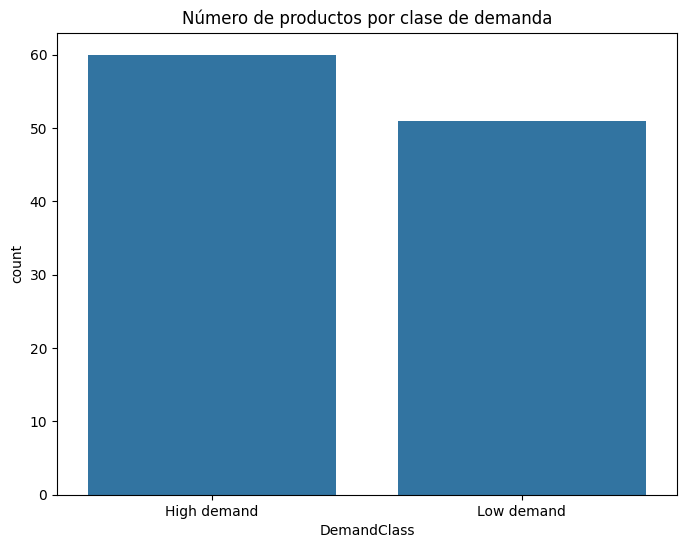

In [48]:
# 5. Número de productos por clase de demanda
plt.figure(figsize=(8, 6))
sns.countplot(x='DemandClass', data=top_products)
plt.title('Número de productos por clase de demanda')
plt.show()

Más o menos está equilibrada la distribución de productos entre clases de demanda

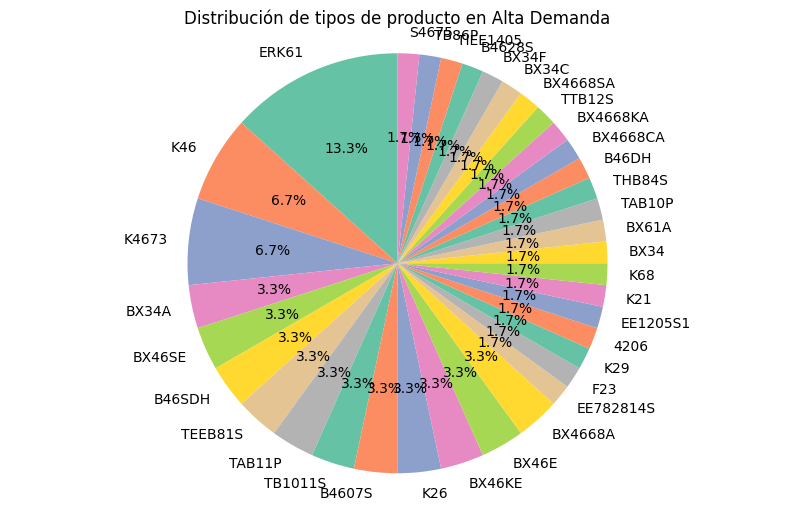

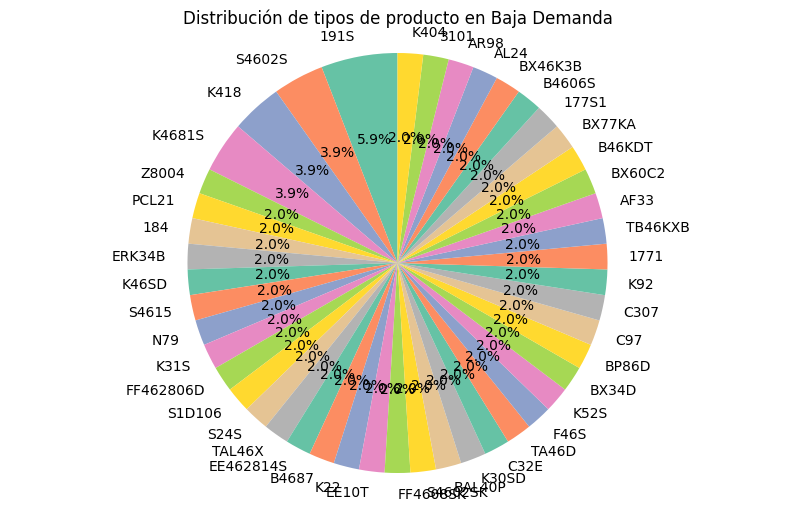

In [ ]:
high_demand_df = top_products[top_products['DemandClass'] == 'High demand']
low_demand_df = top_products[top_products['DemandClass'] == 'Low demand']

# Calculamos la distribución por tipo de producto para cada clase de demanda
high_demand_counts = high_demand_df['ProductType'].value_counts()
low_demand_counts = low_demand_df['ProductType'].value_counts()

# Calculamos los porcentajes
high_demand_percentages = high_demand_counts / high_demand_counts.sum() * 100
low_demand_percentages = low_demand_counts / low_demand_counts.sum() * 100

# Gráfico circular para alta demanda
plt.figure(figsize=(10, 6))
plt.pie(high_demand_percentages, labels=high_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(high_demand_percentages)))
plt.title('Distribución de tipos de producto en Alta Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.show()

# Gráfico circular para baja demanda
plt.figure(figsize=(10, 6))
plt.pie(low_demand_percentages, labels=low_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(low_demand_percentages)))
plt.title('Distribución de tipos de producto en Baja Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.show()


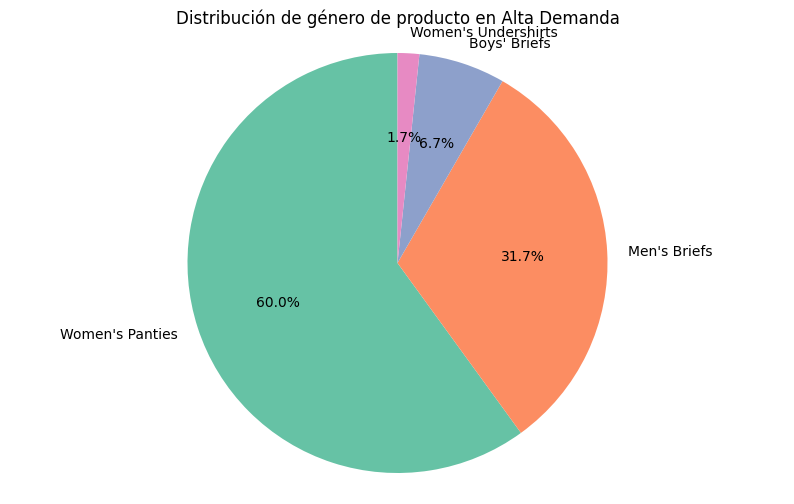

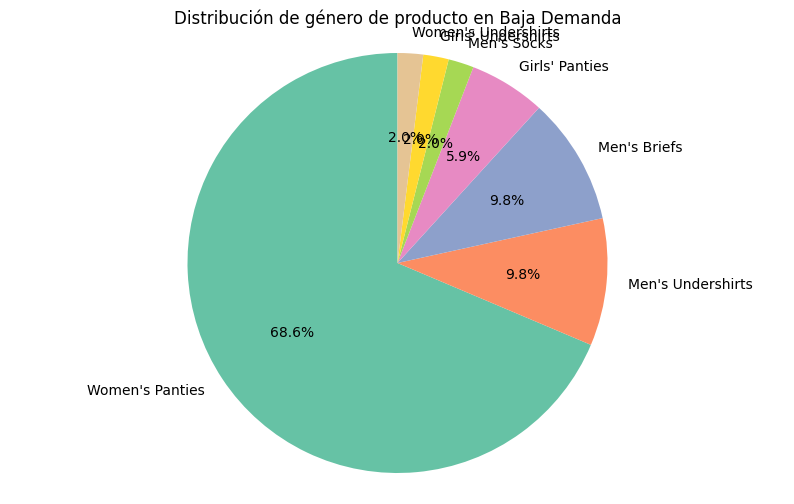

In [55]:

# Filtramos los datos según la clase de demanda
high_demand_df = top_products[top_products['DemandClass'] == 'High demand']
low_demand_df = top_products[top_products['DemandClass'] == 'Low demand']

# Calculamos la distribución por tipo de producto para cada clase de demanda
high_demand_counts = high_demand_df['Gender'].value_counts()
low_demand_counts = low_demand_df['Gender'].value_counts()

# Calculamos los porcentajes
high_demand_percentages = high_demand_counts / high_demand_counts.sum() * 100
low_demand_percentages = low_demand_counts / low_demand_counts.sum() * 100

# Gráfico circular para alta demanda
plt.figure(figsize=(10, 6))
plt.pie(high_demand_percentages, labels=high_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(high_demand_percentages)))
plt.title('Distribución de género de producto en Alta Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()

# Gráfico circular para baja demanda
plt.figure(figsize=(10, 6))
plt.pie(low_demand_percentages, labels=low_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(low_demand_percentages)))
plt.title('Distribución de género de producto en Baja Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()


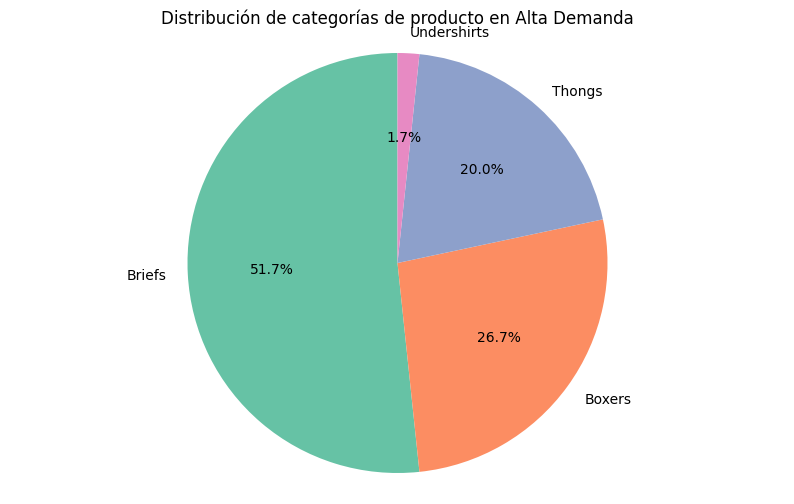

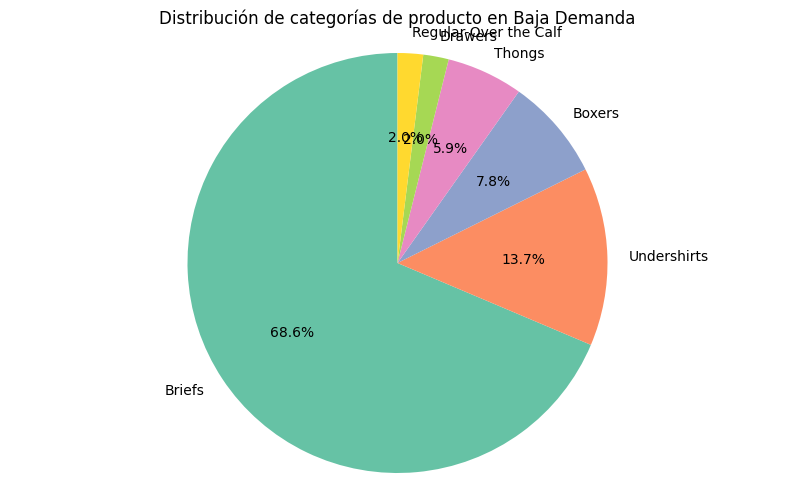

In [56]:

# Filtramos los datos según la clase de demanda
high_demand_df = top_products[top_products['DemandClass'] == 'High demand']
low_demand_df = top_products[top_products['DemandClass'] == 'Low demand']

# Calculamos la distribución por tipo de producto para cada clase de demanda
high_demand_counts = high_demand_df['Category'].value_counts()
low_demand_counts = low_demand_df['Category'].value_counts()

# Calculamos los porcentajes
high_demand_percentages = high_demand_counts / high_demand_counts.sum() * 100
low_demand_percentages = low_demand_counts / low_demand_counts.sum() * 100

# Gráfico circular para alta demanda
plt.figure(figsize=(10, 6))
plt.pie(high_demand_percentages, labels=high_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(high_demand_percentages)))
plt.title('Distribución de categorías de producto en Alta Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()

# Gráfico circular para baja demanda
plt.figure(figsize=(10, 6))
plt.pie(low_demand_percentages, labels=low_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(low_demand_percentages)))
plt.title('Distribución de categorías de producto en Baja Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()


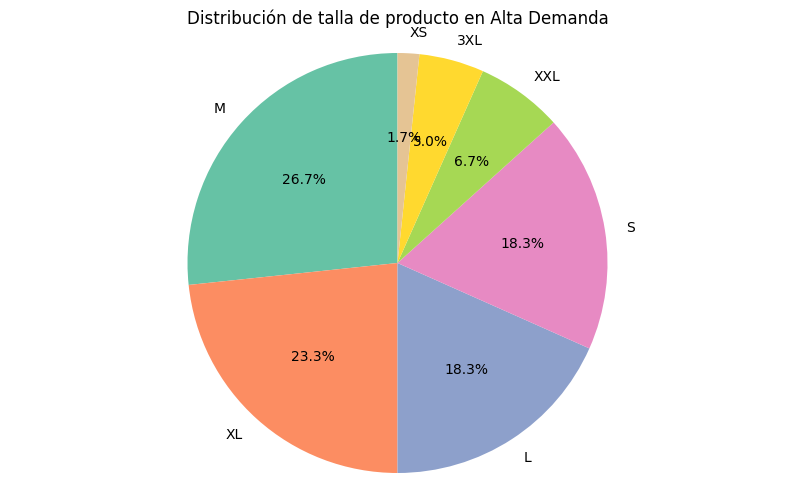

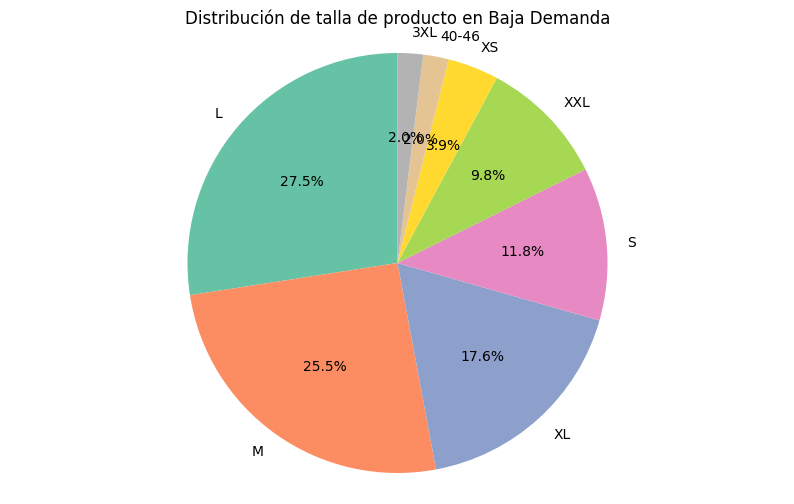

In [57]:

# Filtramos los datos según la clase de demanda
high_demand_df = top_products[top_products['DemandClass'] == 'High demand']
low_demand_df = top_products[top_products['DemandClass'] == 'Low demand']

# Calculamos la distribución por tipo de producto para cada clase de demanda
high_demand_counts = high_demand_df['Size'].value_counts()
low_demand_counts = low_demand_df['Size'].value_counts()

# Calculamos los porcentajes
high_demand_percentages = high_demand_counts / high_demand_counts.sum() * 100
low_demand_percentages = low_demand_counts / low_demand_counts.sum() * 100

# Gráfico circular para alta demanda
plt.figure(figsize=(10, 6))
plt.pie(high_demand_percentages, labels=high_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(high_demand_percentages)))
plt.title('Distribución de talla de producto en Alta Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()

# Gráfico circular para baja demanda
plt.figure(figsize=(10, 6))
plt.pie(low_demand_percentages, labels=low_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(low_demand_percentages)))
plt.title('Distribución de talla de producto en Baja Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()


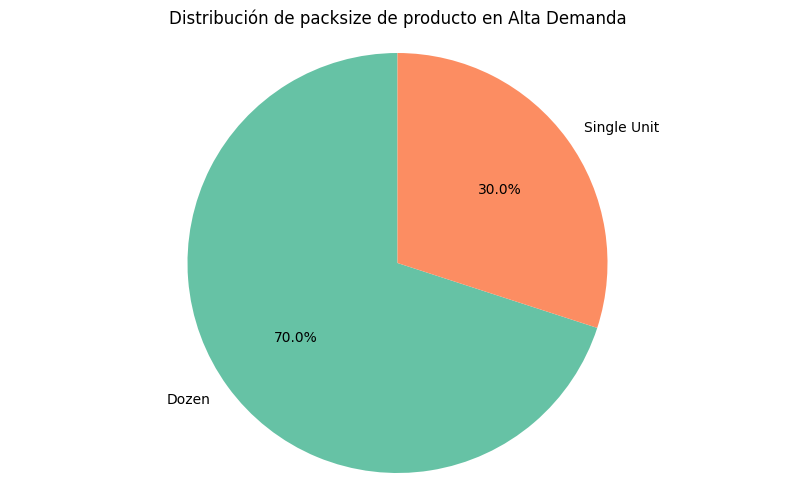

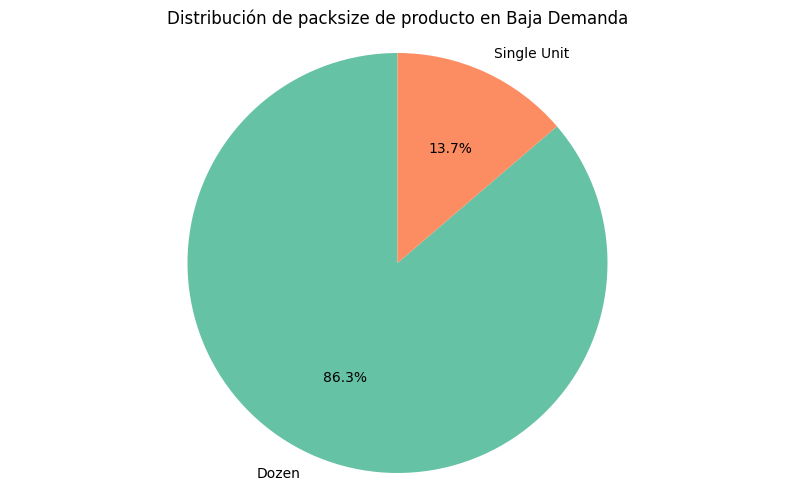

In [58]:

# Filtramos los datos según la clase de demanda
high_demand_df = top_products[top_products['DemandClass'] == 'High demand']
low_demand_df = top_products[top_products['DemandClass'] == 'Low demand']

# Calculamos la distribución por tipo de producto para cada clase de demanda
high_demand_counts = high_demand_df['PackSize'].value_counts()
low_demand_counts = low_demand_df['PackSize'].value_counts()

# Calculamos los porcentajes
high_demand_percentages = high_demand_counts / high_demand_counts.sum() * 100
low_demand_percentages = low_demand_counts / low_demand_counts.sum() * 100

# Gráfico circular para alta demanda
plt.figure(figsize=(10, 6))
plt.pie(high_demand_percentages, labels=high_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(high_demand_percentages)))
plt.title('Distribución de packsize de producto en Alta Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()

# Gráfico circular para baja demanda
plt.figure(figsize=(10, 6))
plt.pie(low_demand_percentages, labels=low_demand_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(low_demand_percentages)))
plt.title('Distribución de packsize de producto en Baja Demanda')
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
plt.xticks(rotation=45)
plt.show()


##### **Study by Category Class**

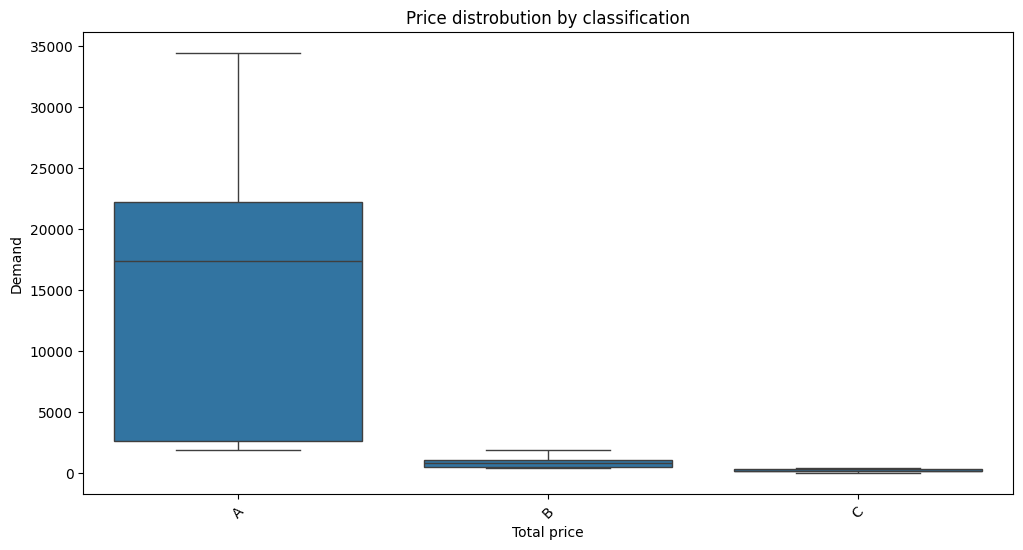

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Classification', y='total_price', data=top_products)
plt.title('Price distrobution by classification')
plt.xticks(rotation=45)
plt.xlabel('Total price')
plt.ylabel('Demand')
plt.show()

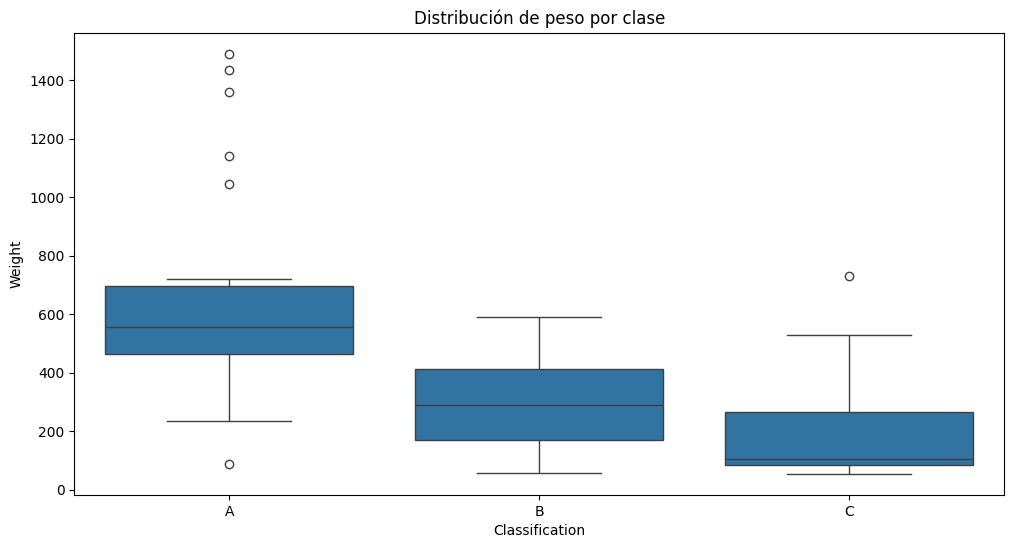

In [62]:
# 2. Promedio de peso y tamaño por clase de demanda
plt.figure(figsize=(12, 6))
sns.boxplot(x='Classification', y='Weight', data=top_products)
plt.title('Distribución de peso por clase')
plt.show()

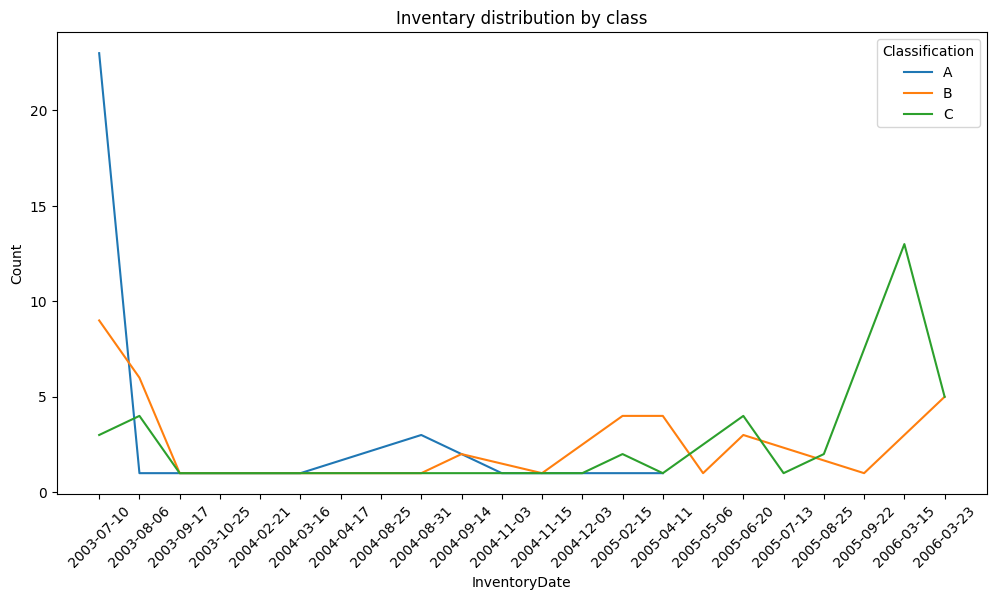

In [65]:
# 4. Distribución del inventario por clase de demanda
df_grouped_demand = top_products.groupby(['InventoryDate', 'Classification']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.lineplot(x='InventoryDate', y='Count', hue='Classification', data=df_grouped_demand)
plt.title('Inventary distribution by class')
plt.xticks(rotation=45)
plt.show()

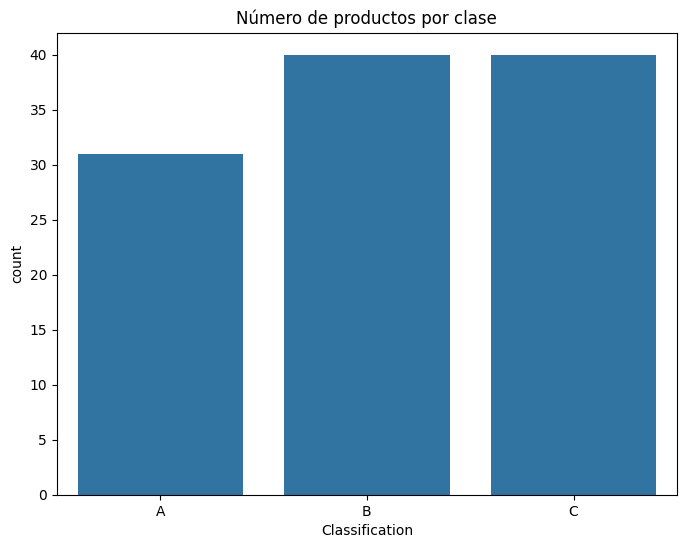

In [66]:
# 5. Número de productos por clase de demanda
plt.figure(figsize=(8, 6))
sns.countplot(x='Classification', data=top_products)
plt.title('Número de productos por clase')
plt.show()

In [73]:
def plot_class(top_products, name):
    
    class_a_df = top_products[top_products['Classification'] == 'A']
    class_b_df = top_products[top_products['Classification'] == 'B']
    class_c_df = top_products[top_products['Classification'] == 'C']

    class_a_counts = class_a_df[name].value_counts()
    class_b_counts = class_b_df[name].value_counts()
    class_c_counts = class_c_df[name].value_counts()



    # Calculamos los porcentajes
    a_percentages = class_a_counts / class_a_counts.sum() * 100
    b_percentages = class_b_counts / class_b_counts.sum() * 100
    c_percentages = class_c_counts / class_c_counts.sum() * 100


    plt.figure(figsize=(10, 6))
    plt.pie(a_percentages, labels=a_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(a_percentages)))
    plt.title(f'Distribution of {name} in A')
    plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.pie(b_percentages, labels=b_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(b_percentages)))
    plt.title(f'Distribution of {name} in B')
    plt.axis('equal')  
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.pie(c_percentages, labels=c_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(c_percentages)))
    plt.title(f'Distribution of {name} in C')
    plt.axis('equal')  
    plt.xticks(rotation=45)
    plt.show()



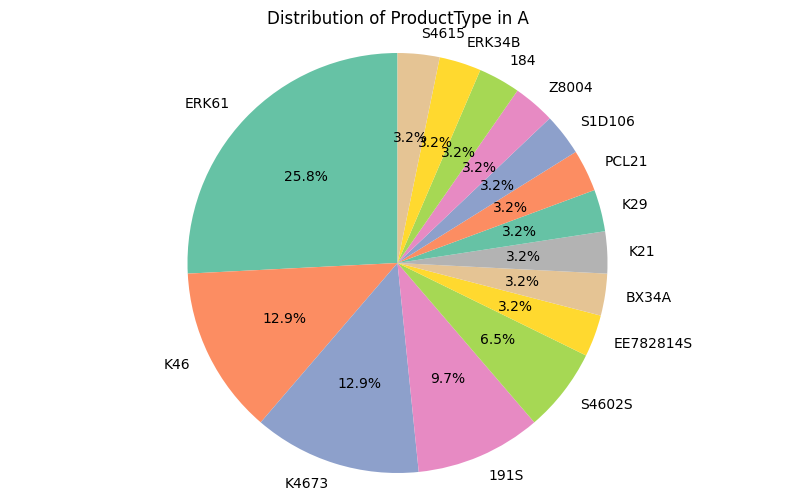

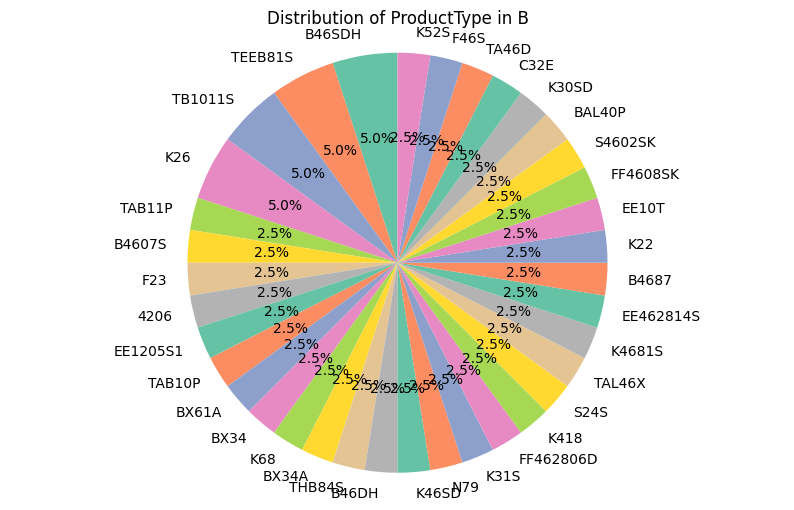

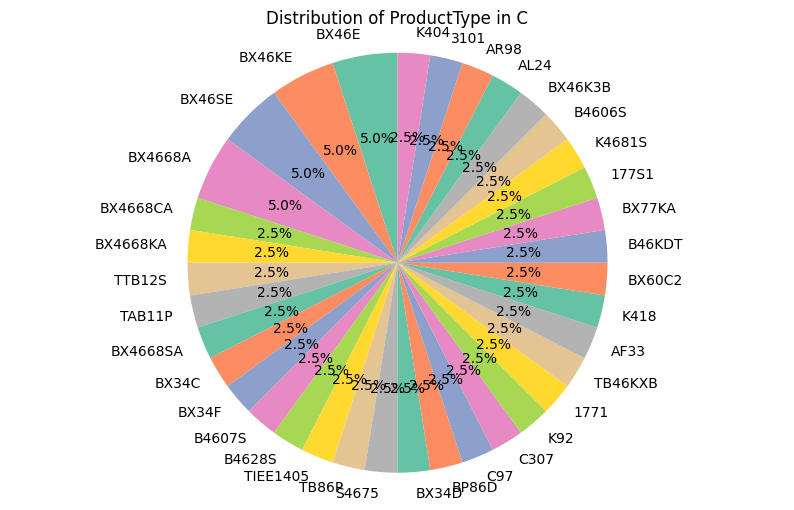

In [74]:
plot_class(top_products, 'ProductType')

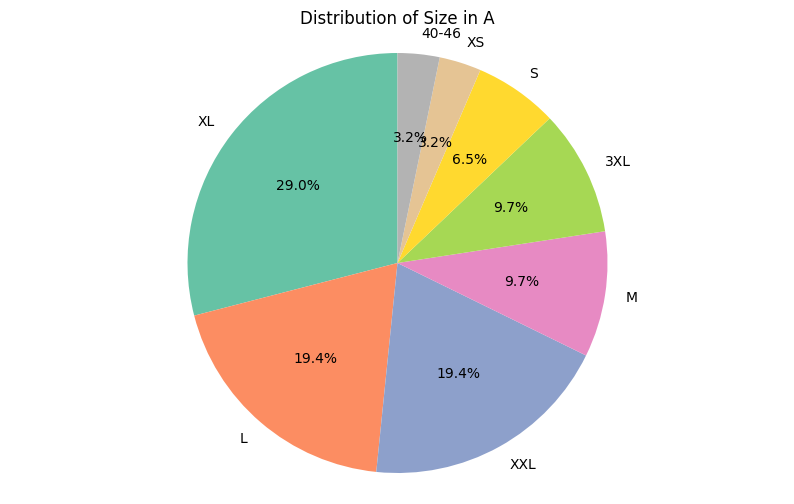

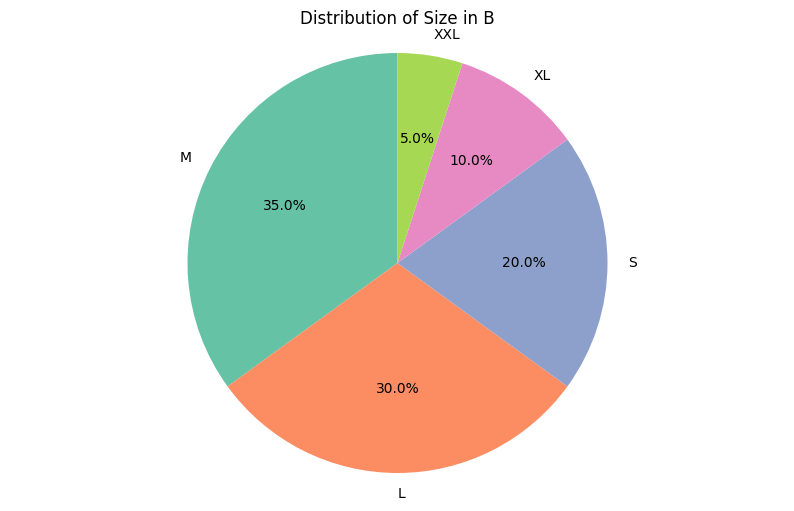

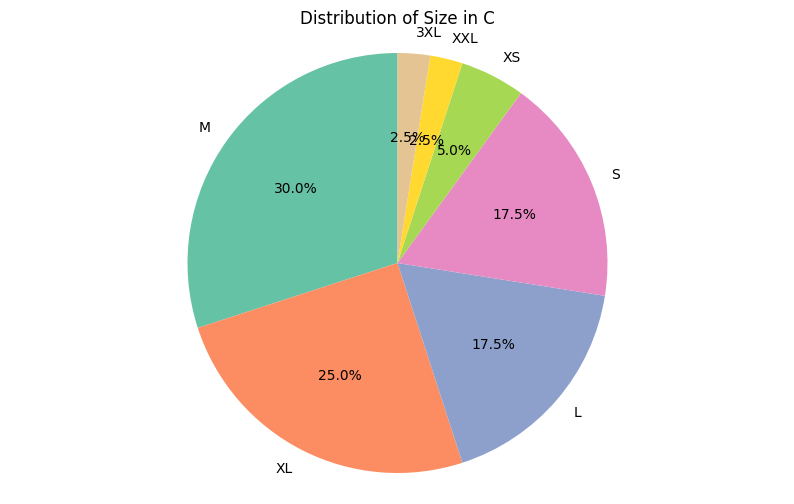

In [75]:
plot_class(top_products, 'Size')

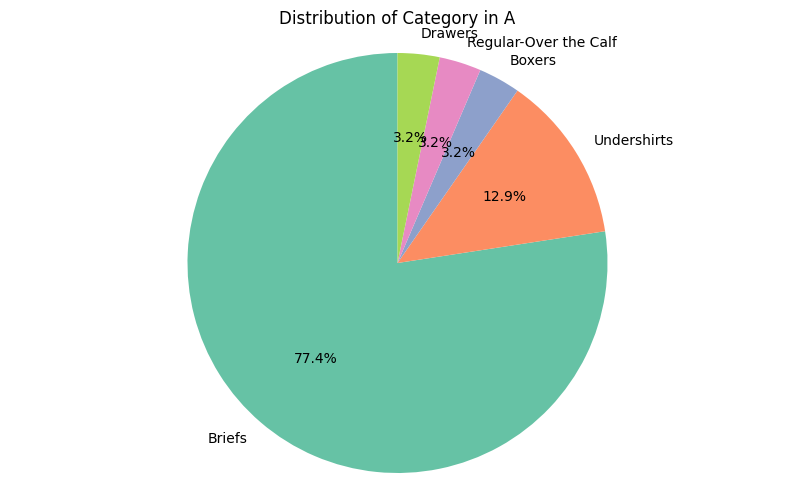

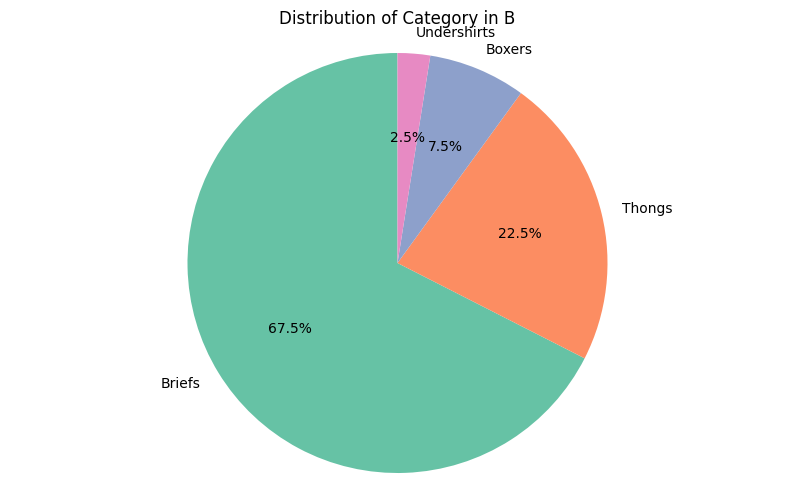

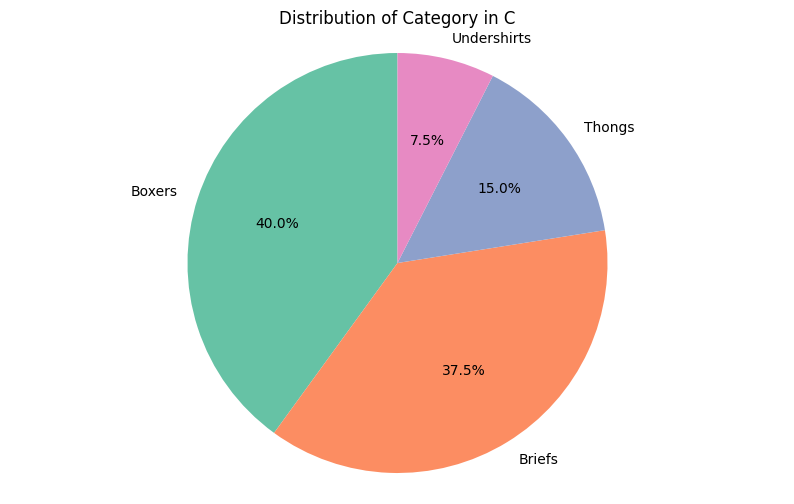

In [76]:
plot_class(top_products, 'Category')

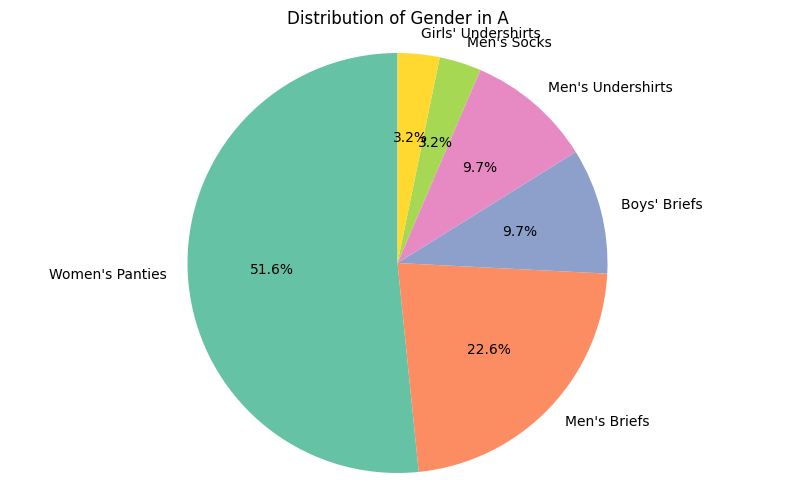

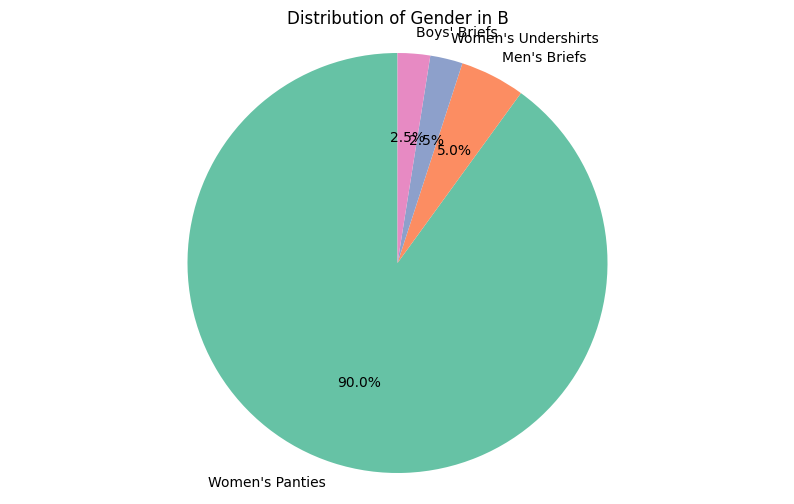

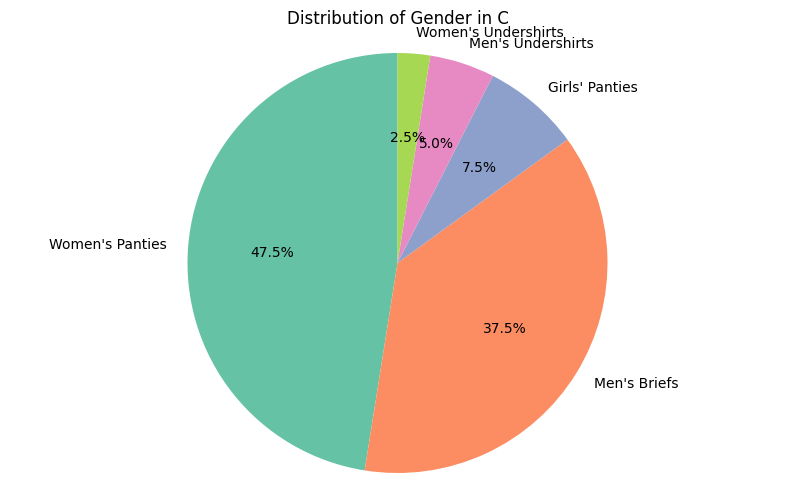

In [77]:
plot_class(top_products, 'Gender')

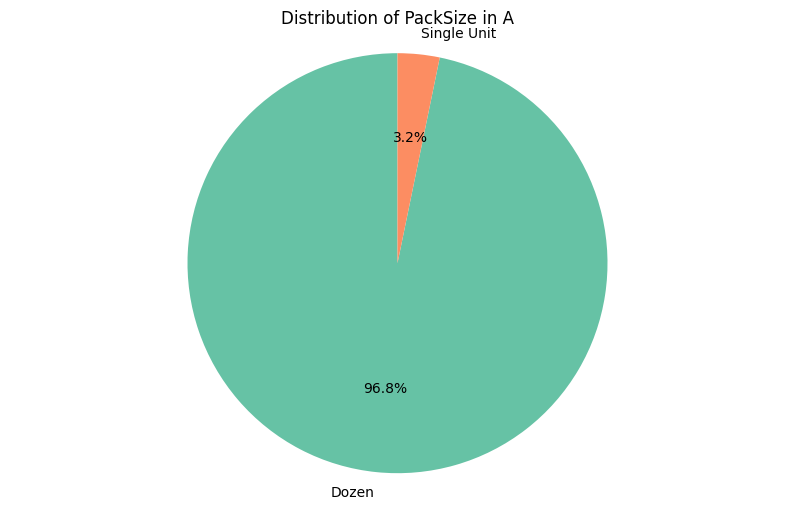

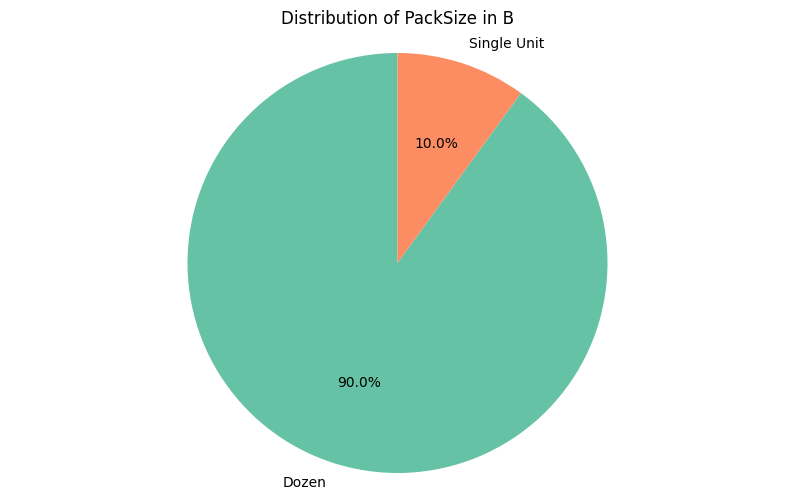

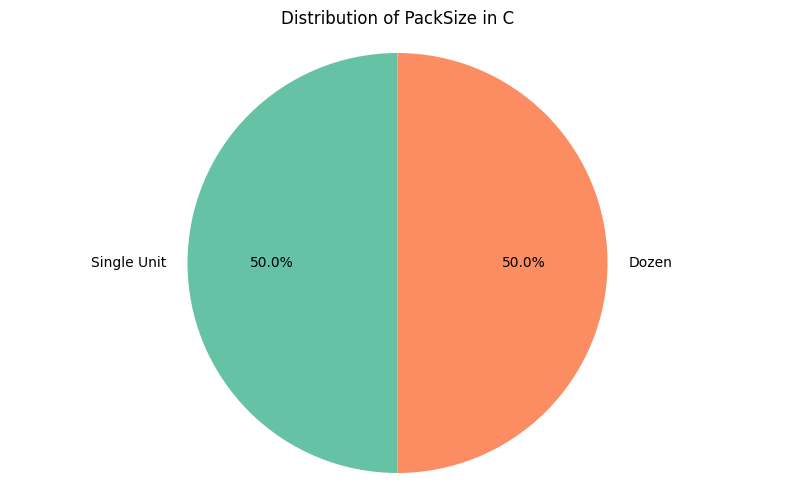

In [78]:
plot_class(top_products, 'PackSize')

## Apply forecasting models

#### 1. High demand - A/B Class

In [79]:
final_products

ProductID  total_price  Accumulative Percentage Classification  \
0           427      34465.0                 0.008749              A   
1           183      31866.1                 0.016838              A   
2           932      28693.7                 0.024121              A   
3           856      28052.7                 0.031242              A   
4           989      25377.5                 0.037684              A   
...         ...          ...                      ...            ...   
4036        387          1.2                 0.999999              C   
4037        675          1.1                 1.000000              C   
4038       4300          1.0                 1.000000              C   
4039       2088          0.0                 1.000000              C   
4040       2640          0.0                 1.000000              C   

      AverageDemand  NullPercentage  DemandClass  
0        220.794118             0.0  High demand  
1        182.588235             0.0  High demand  
2        158.862069             0.0  High demand  
3        142.500000             0.0  High demand  
4        110.764706             0.0  High demand  
...             ...             ...          ...  
4036       1.000000             0.0   Low demand  
4037       1.000000             0.0   Low demand  
4038       1.000000             0.0   Low demand  
4039       0.000000             1.0   Low demand  
4040       0.000000             1.0   Low demand  

[4041 rows x 7 columns]

In [82]:
df_product_a = final_products[final_products['Classification'] == 'A']
df_product_a = df_product_a.sort_values(by='AverageDemand', ascending=False)
df_product_a

ProductID  total_price  Accumulative Percentage Classification  \
0          427     34465.00                 0.008749              A   
8            9     22054.00                 0.061403              A   
220       2580      3305.10                 0.458093              A   
1          183     31866.10                 0.016838              A   
18          72     18564.50                 0.112941              A   
..         ...          ...                      ...            ...   
414        182      1988.82                 0.583104              A   
404       1883      2038.60                 0.578006              A   
381       1871      2140.30                 0.565840              A   
227        120      3214.40                 0.463849              A   
304        895      2613.10                 0.520022              A   

     AverageDemand  NullPercentage  DemandClass  
0       220.794118        0.000000  High demand  
8       193.250000        0.000000  High demand  
220     190.000000        0.000000  High demand  
1       182.588235        0.000000  High demand  
18      174.312500        0.000000  High demand  
..             ...             ...          ...  
414       8.800000        0.000000   Low demand  
404       8.800000        0.000000   Low demand  
381       8.687500        0.000000   Low demand  
227       8.464286        0.107143   Low demand  
304       6.500000        0.076923   Low demand  

[449 rows x 7 columns]

In [83]:
len(df_product_a), len(df_product_a)*0.2

(449, 89.80000000000001)

In [84]:
percentage_20 = round(len(df_product_a)*0.2)
percentage_20

90

In [96]:
df_product_a_20 = df_product_a[:20]
df_product_a_20

ProductID  total_price  Accumulative Percentage Classification  \
0          427      34465.0                 0.008749              A   
8            9      22054.0                 0.061403              A   
220       2580       3305.1                 0.458093              A   
1          183      31866.1                 0.016838              A   
18          72      18564.5                 0.112941              A   
2          932      28693.7                 0.024121              A   
23          52      15640.3                 0.135320              A   
10         678      21513.5                 0.072445              A   
3          856      28052.7                 0.031242              A   
6          252      23987.6                 0.050126              A   
5          806      25028.1                 0.044037              A   
100        155       6670.7                 0.321644              A   
4          989      25377.5                 0.037684              A   
9          861      21984.5                 0.066984              A   
7          940      22372.2                 0.055805              A   
25         830      14861.2                 0.142934              A   
14         968      19865.0                 0.093301              A   
21         261      18173.9                 0.126929              A   
22         819      17416.4                 0.131350              A   
12         991      20650.9                 0.083112              A   

     AverageDemand  NullPercentage  DemandClass  
0       220.794118             0.0  High demand  
8       193.250000             0.0  High demand  
220     190.000000             0.0  High demand  
1       182.588235             0.0  High demand  
18      174.312500             0.0  High demand  
2       158.862069             0.0  High demand  
23      153.875000             0.0  High demand  
10      151.588235             0.0  High demand  
3       142.500000             0.0  High demand  
6       133.500000             0.0  High demand  
5       133.470588             0.0  High demand  
100     126.969697             0.0  High demand  
4       110.764706             0.0  High demand  
9       107.766667             0.0  High demand  
7       105.000000             0.0  High demand  
25      100.161290             0.0  High demand  
14       98.687500             0.0  High demand  
21       96.064516             0.0  High demand  
22       95.911765             0.0  High demand  
12       92.413793             0.0  High demand

In [97]:
# group by df_order and df_order_details to achieve quantity sold

df_class_a = df_product_a_20.merge(df_orders_details, on='ProductID')
df_class_a = df_class_a.merge(df_orders, on="OrderID")
df_class_a

ProductID  total_price_x  Accumulative Percentage Classification  \
0           427        34465.0                 0.008749              A   
1           427        34465.0                 0.008749              A   
2           427        34465.0                 0.008749              A   
3           427        34465.0                 0.008749              A   
4           427        34465.0                 0.008749              A   
...         ...            ...                      ...            ...   
6918        991        20650.9                 0.083112              A   
6919        991        20650.9                 0.083112              A   
6920        991        20650.9                 0.083112              A   
6921        991        20650.9                 0.083112              A   
6922        991        20650.9                 0.083112              A   

      AverageDemand  NullPercentage  DemandClass  OrderDetailID  OrderID  \
0        220.794118             0.0  High demand             17        4   
1        220.794118             0.0  High demand             49        5   
2        220.794118             0.0  High demand             78        7   
3        220.794118             0.0  High demand            108        8   
4        220.794118             0.0  High demand            170       13   
...             ...             ...          ...            ...      ...   
6918      92.413793             0.0  High demand         110910     2400   
6919      92.413793             0.0  High demand         111291     2402   
6920      92.413793             0.0  High demand         111301     2400   
6921      92.413793             0.0  High demand         113535     2446   
6922      92.413793             0.0  High demand         114381     2468   

      QuantitySold  ...  total_price_y  CustomerID  EmployeeID  \
0               50  ...          205.0           2           2   
1               50  ...          205.0           2           1   
2               20  ...           82.0           4           1   
3               25  ...          102.5           5           1   
4               50  ...          205.0           2           1   
...            ...  ...            ...         ...         ...   
6918             5  ...           44.5          25          14   
6919             5  ...           53.5          42           8   
6920            15  ...          133.5          25          14   
6921            10  ...           96.0         231           8   
6922             3  ...           32.1          82           8   

      ShippingMethodID   OrderDate    ShipDate FreightCharge  DeliveryTime  \
0                    1  2003-07-11  2003-07-11           0.0             0   
1                    1  2003-07-15  2003-07-15           0.0             0   
2                    1  2003-07-14  2003-07-15           0.0             1   
3                    1  2003-07-14  2003-07-14           0.0             0   
4                    1  2003-07-18  2003-07-18           0.0             0   
...                ...         ...         ...           ...           ...   
6918                 1  2006-03-24  2006-03-24           0.0             0   
6919                 1  2006-03-25  2006-03-25          31.0             0   
6920                 1  2006-03-24  2006-03-24           0.0             0   
6921                 1  2006-04-06  2006-04-06           0.0             0   
6922                 1  2006-04-18  2006-04-18          31.0             0   

      OrderYear  OrderMonth  
0          2003           7  
1          2003           7  
2          2003           7  
3          2003           7  
4          2003           7  
...         ...         ...  
6918       2006           3  
6919       2006           3  
6920       2006           3  
6921       2006           4  
6922       2006           4  

[6923 rows x 21 columns]

In [109]:
df_class_a['OrderDate'] = pd.to_datetime(df_class_a['OrderDate'])
df_class_a.dtypes

ProductID                           int64
total_price_x                     float64
Accumulative Percentage           float64
Classification                     object
AverageDemand                     float64
NullPercentage                    float64
DemandClass                        object
OrderDetailID                       int64
OrderID                             int64
QuantitySold                        int64
UnitSalesPrice                    float64
total_price_y                     float64
CustomerID                          int64
EmployeeID                          int64
ShippingMethodID                    int64
OrderDate                  datetime64[ns]
ShipDate                           object
FreightCharge                     float64
DeliveryTime                        int64
OrderYear                           int64
OrderMonth                          int64
dtype: object

In [93]:
list_product_id = df_class_a['ProductID'].unique()
list_product_id

array([ 427,    9, 2580,  183,   72,  932,   52,  678,  856,  252,  806,
        155,  989,  861,  940,  830,  968,  261,  819,  991,  995,  792,
        945,  944, 1011,  196, 1009,  920,  831,  996, 1010,  865,  992,
        439,  835,  866,  910,  210,  504,  915,  941,  926,  382,  836,
        820,  921,   35, 2406,  209,  197, 2464,  864,  262,  202,  200,
        219,  216,  513,  833, 2427, 1001,  913,  832,  980,  447,  975,
        267, 1130,  862, 2934,  911,  220,  286,  824,  579,  927,  943,
       1921, 3425, 2463,  430,  822,  215, 1988, 1333,   25,  974, 2057,
       1132, 1857])

In [94]:
list_product_id[0]

np.int64(427)

In [ ]:
#df_sales_a = df_class_a[df_class_a['ProductID'] == list_product_id[0]]
#df_sales_a

ProductID  total_price_x  Accumulative Percentage Classification  \
0          427        34465.0                 0.008749              A   
1          427        34465.0                 0.008749              A   
2          427        34465.0                 0.008749              A   
3          427        34465.0                 0.008749              A   
4          427        34465.0                 0.008749              A   
..         ...            ...                      ...            ...   
466        427        34465.0                 0.008749              A   
467        427        34465.0                 0.008749              A   
468        427        34465.0                 0.008749              A   
469        427        34465.0                 0.008749              A   
470        427        34465.0                 0.008749              A   

     AverageDemand  NullPercentage  DemandClass  OrderDetailID  OrderID  \
0       220.794118             0.0  High demand             17        4   
1       220.794118             0.0  High demand             49        5   
2       220.794118             0.0  High demand             78        7   
3       220.794118             0.0  High demand            108        8   
4       220.794118             0.0  High demand            170       13   
..             ...             ...          ...            ...      ...   
466     220.794118             0.0  High demand         109048     2378   
467     220.794118             0.0  High demand         111321     2405   
468     220.794118             0.0  High demand         111446     2408   
469     220.794118             0.0  High demand         112624     2430   
470     220.794118             0.0  High demand         114271     2464   

     QuantitySold  ...  total_price_y  CustomerID  EmployeeID  \
0              50  ...          205.0           2           2   
1              50  ...          205.0           2           1   
2              20  ...           82.0           4           1   
3              25  ...          102.5           5           1   
4              50  ...          205.0           2           1   
..            ...  ...            ...         ...         ...   
466             5  ...           29.5         186          16   
467             1  ...            7.3         245          16   
468             1  ...            7.0         246          14   
469            27  ...          162.0         231          14   
470            10  ...           61.0         182           1   

     ShippingMethodID  OrderDate    ShipDate FreightCharge  DeliveryTime  \
0                   1 2003-07-11  2003-07-11           0.0             0   
1                   1 2003-07-15  2003-07-15           0.0             0   
2                   1 2003-07-14  2003-07-15           0.0             1   
3                   1 2003-07-14  2003-07-14           0.0             0   
4                   1 2003-07-18  2003-07-18           0.0             0   
..                ...        ...         ...           ...           ...   
466                 1 2006-03-18  2006-03-18           0.0             0   
467                 1 2006-04-01  2006-04-01          31.0             0   
468                 1 2006-04-01  2006-04-01          31.0             0   
469                 1 2006-04-01  2006-04-01           0.0             0   
470                 1 2006-04-13  2006-04-13          31.0             0   

     OrderYear  OrderMonth  
0         2003           7  
1         2003           7  
2         2003           7  
3         2003           7  
4         2003           7  
..         ...         ...  
466       2006           3  
467       2006           4  
468       2006           4  
469       2006           4  
470       2006           4  

[471 rows x 21 columns]

In [110]:
df_sales_a = df_class_a.groupby('OrderDate').agg(
    TotalQuantitySold = ('QuantitySold', 'sum')
).reset_index()
df_sales_a

OrderDate  TotalQuantitySold
0   2003-07-11                280
1   2003-07-14                245
2   2003-07-15                370
3   2003-07-16                100
4   2003-07-17                 40
..         ...                ...
655 2006-04-13                190
656 2006-04-14                  4
657 2006-04-18                 18
658 2006-04-19                150
659 2006-04-20                  1

[660 rows x 2 columns]

In [111]:
df_sales_a = df_sales_a.set_index('OrderDate')
df_sales_a = df_sales_a.asfreq('W-MON')

df_sales_a['TotalQuantitySold'] = df_sales_a['TotalQuantitySold'].interpolate()
df_sales_a

TotalQuantitySold
OrderDate                    
2003-07-14         245.000000
2003-07-21          90.000000
2003-07-28          93.000000
2003-08-04         164.000000
2003-08-11         100.000000
...                       ...
2006-03-20          58.666667
2006-03-27           3.000000
2006-04-03          50.000000
2006-04-10           8.000000
2006-04-17           8.000000

[145 rows x 1 columns]

In [112]:
mean_value = df_sales_a['TotalQuantitySold'].mean()

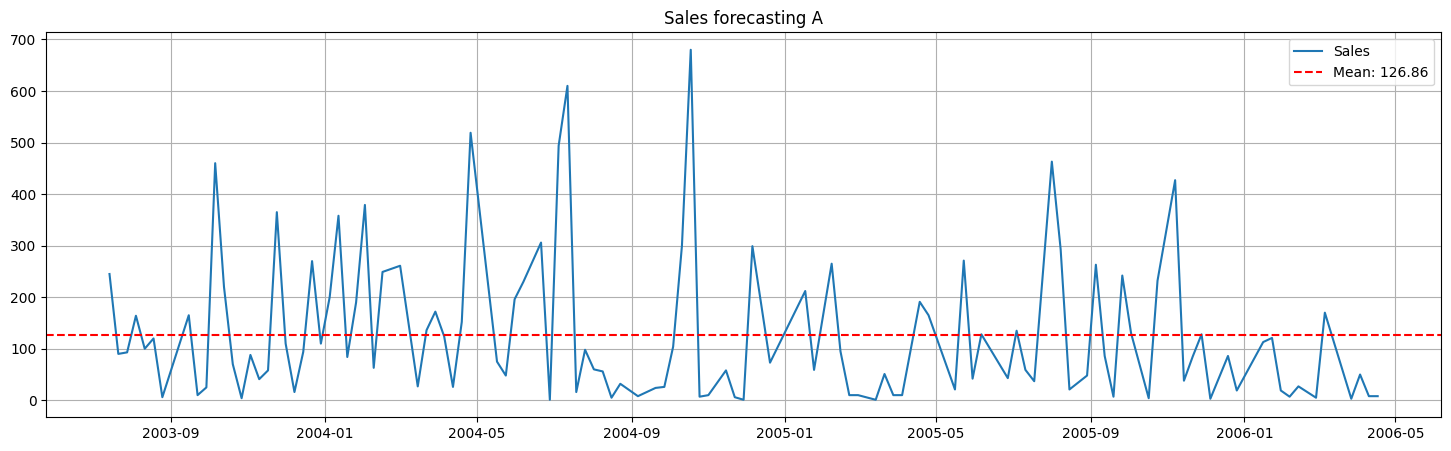

In [113]:
plt.figure(figsize=(18,5))
plt.plot(df_sales_a['TotalQuantitySold'], linestyle="-", label = 'Sales')
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting A')
plt.legend()
plt.grid()
plt.show()

<Axes: ylabel='TotalQuantitySold'>

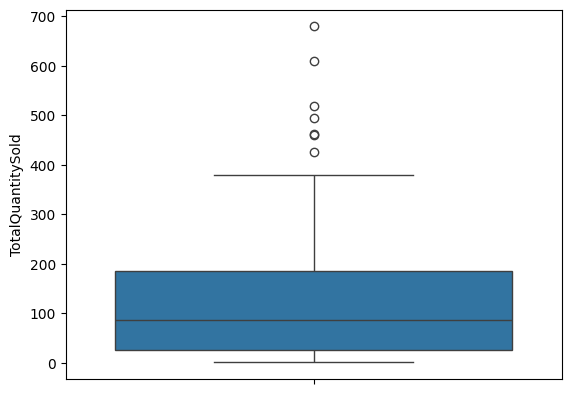

In [114]:
sns.boxplot(df_sales_a['TotalQuantitySold'])

In [115]:
q1 = df_sales_a['TotalQuantitySold'].quantile(0.25)
q3 = df_sales_a['TotalQuantitySold'].quantile(0.75)

iqr = q3-q1

lim_inf = q1 - 1.5*iqr
lim_sup = q3 + 1.5*iqr

outliers = df_sales_a[(df_sales_a['TotalQuantitySold'] < lim_inf) | (df_sales_a['TotalQuantitySold'] > lim_sup)]

perc_out = (len(outliers) / len(df_sales_a['TotalQuantitySold'])) * 100

print(f'Percentage outliers:  {perc_out}')

Percentage outliers:  4.827586206896552


In [116]:
df_sales_a['TotalQuantitySold'].mean(), df_sales_a['TotalQuantitySold'].median()

(np.float64(126.86206896551724), np.float64(86.0))

In [117]:
# sustituimos los valores atipicos por la mediana

df_sales_a['QuantitySold_no_out'] = np.where((df_sales_a['TotalQuantitySold'] < lim_inf) | (df_sales_a['TotalQuantitySold']  > lim_sup),
                              df_sales_a['TotalQuantitySold'] .median(), df_sales_a['TotalQuantitySold'] )

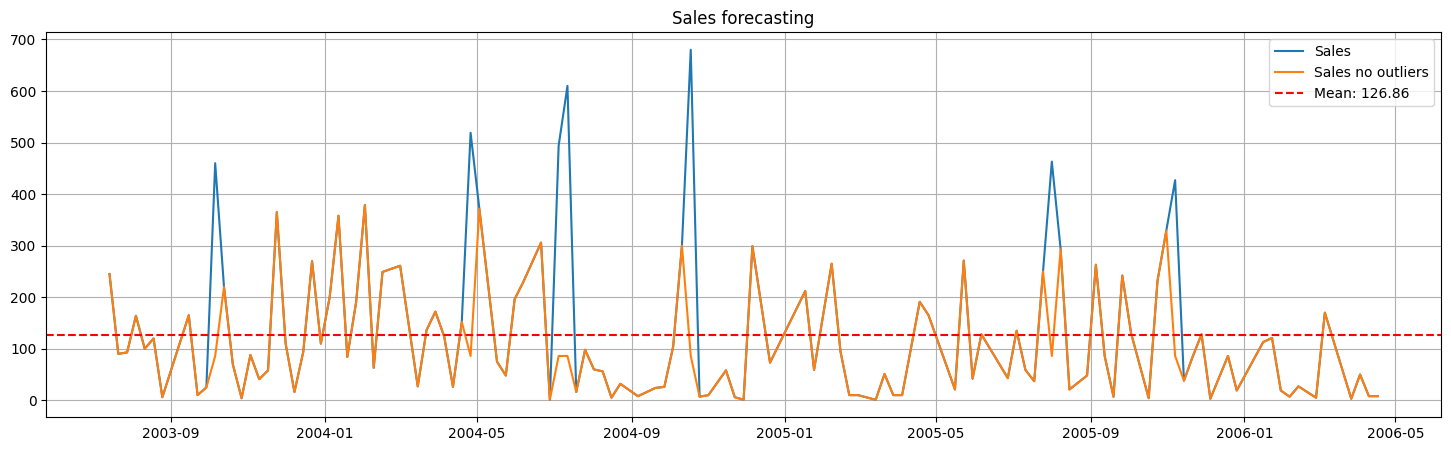

In [118]:
plt.figure(figsize=(18,5))
plt.plot(df_sales_a['TotalQuantitySold'], linestyle="-", label = 'Sales')
plt.plot(df_sales_a['QuantitySold_no_out'], linestyle="-", label = 'Sales no outliers' )
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()

In [120]:
df_sales_a['TotalQuantitySold'] = df_sales_a['QuantitySold_no_out']
df_sales_a.drop(columns=['QuantitySold_no_out'], inplace=True)

p-value Kolmogorov-Smirnov: 8.639759623652355e-80
p-value Shapiro-Wilk: 3.075605426220931e-09


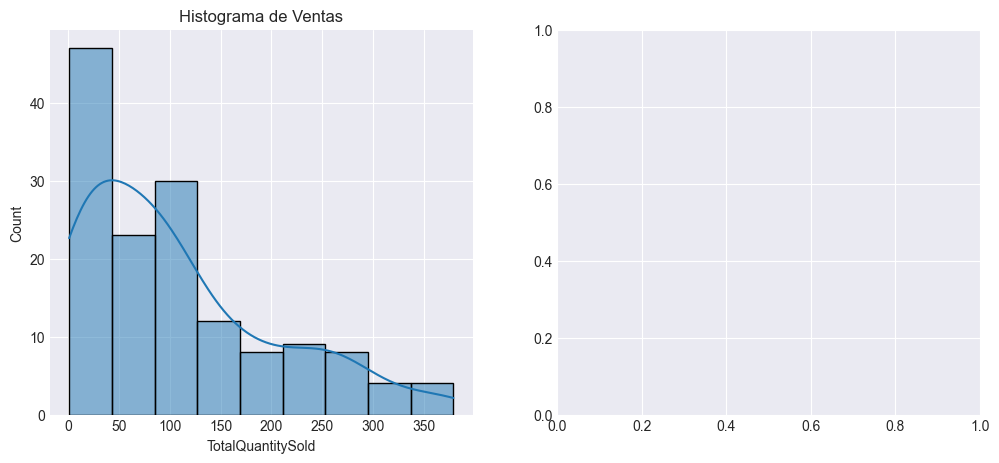

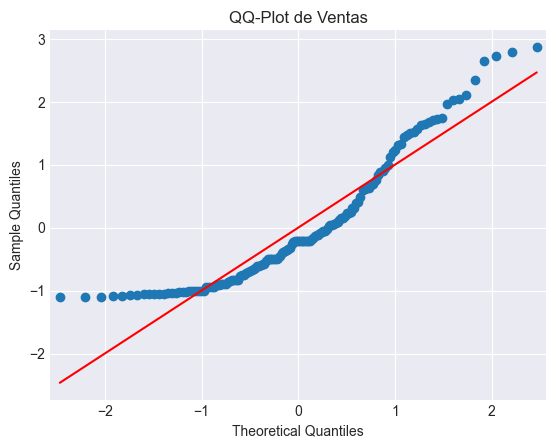

La serie NO es normal. Aplicando Box-Cox...
Lambda de Box-Cox: 0.3191945274030105


In [128]:
# comprobar la normalidad

from scipy.stats import shapiro, ks_2samp
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import boxcox, norm, ks_2samp

residuos = df_sales_a['TotalQuantitySold']

# Test de Kolmogorov-Smirnov
ks_stat, p_ks = ks_2samp(residuos, norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(residuos) if len(residuos) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(residuos, kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

# Si p-valor < 0.05 en ambos test, la serie no es normal -> aplicar Box-Cox
if p_ks < 0.05 or (p_shapiro is not None and p_shapiro < 0.05):
    print("La serie NO es normal. Aplicando Box-Cox...")
    df_sales_a['TotalQuantitySold'] = df_sales_a['TotalQuantitySold'] + 1e-6
    df_sales_a['TotalQuantitySold'], lambda_bc = boxcox(df_sales_a['TotalQuantitySold'])
    print(f"Lambda de Box-Cox: {lambda_bc}")
else:
    print("La serie es normal. No es necesario aplicar Box-Cox.")

p-value Kolmogorov-Smirnov: 7.57419620253969e-70
p-value Shapiro-Wilk: 0.010661813533584136


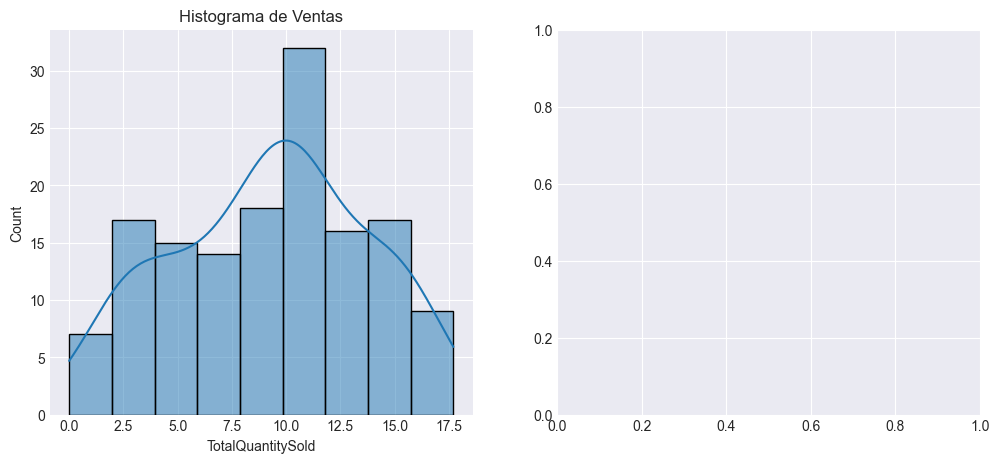

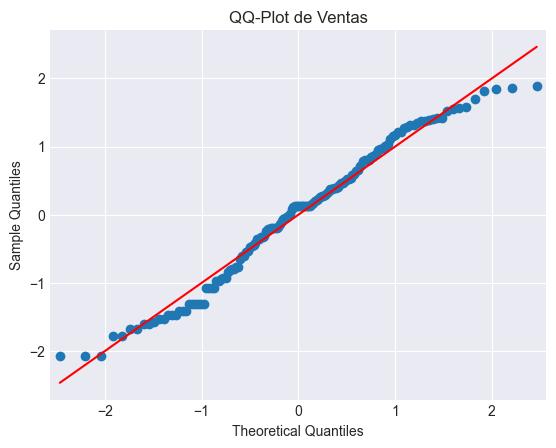

In [131]:
ks_stat, p_ks = ks_2samp(df_sales_a['TotalQuantitySold'], norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(df_sales_a['TotalQuantitySold']) if len(df_sales_a['TotalQuantitySold']) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(df_sales_a['TotalQuantitySold'], kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(df_sales_a['TotalQuantitySold'], line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

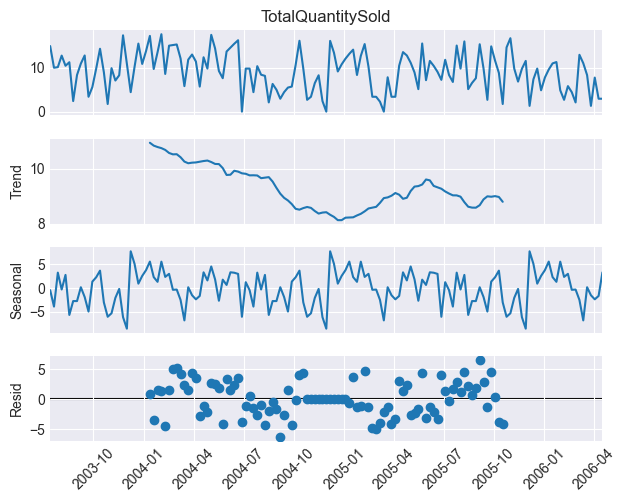

In [132]:
# descomposicion de la serie temporal

descomposicion = sm.tsa.seasonal_decompose(df_sales_a['TotalQuantitySold'], model='additive')
descomposicion.plot()
plt.xticks(rotation = 45)
plt.show()

In [133]:
#train = round(len(sales)*0.9)
train = round(len(df_sales_a)*0.8)

train_data = df_sales_a[:int(train)]['TotalQuantitySold']
test_data = df_sales_a[int(train):]['TotalQuantitySold']
train_data.shape, test_data.shape

((116,), (29,))

In [134]:
train_data, test_data

(OrderDate
 2003-07-14    15.003607
 2003-07-21    10.041430
 2003-07-28    10.180041
 2003-08-04    12.822621
 2003-08-11    10.492024
                 ...    
 2005-08-29     7.646340
 2005-09-05    15.418707
 2005-09-12     9.851634
 2005-09-19     2.697473
 2005-09-26    14.932423
 Freq: W-MON, Name: TotalQuantitySold, Length: 116, dtype: float64,
 OrderDate
 2005-10-03    11.682184
 2005-10-10     8.857072
 2005-10-17     1.743734
 2005-10-24    14.690712
 2005-10-31    16.802757
 2005-11-07     9.851634
 2005-11-14     6.871786
 2005-11-21     9.803249
 2005-11-28    11.609048
 2005-12-05     1.315876
 2005-12-12     7.388963
 2005-12-19     9.851634
 2005-12-26     4.886032
 2006-01-02     7.810900
 2006-01-09     9.639111
 2006-01-16    11.034051
 2006-01-23    11.346771
 2006-01-30     4.886032
 2006-02-06     2.697473
 2006-02-13     5.837850
 2006-02-20     4.458011
 2006-02-27     2.103746
 2006-03-06    13.006673
 2006-03-13    11.087196
 2006-03-20     8.359374
 2006-03-2

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -5.168808820838358, p-value: 1.0177064380112662e-05
KPSS Statistic: 0.43530163659205295, p-value: 0.06193894974480477

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -6.028863662766968, p-value: 1.4339504279219245e-07
KPSS Statistic: 0.1457914309565783, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -7.333996332445685, p-value: 1.1087975963822171e-10
KPSS Statistic: 0.14204557216816177, p-value: 0.1


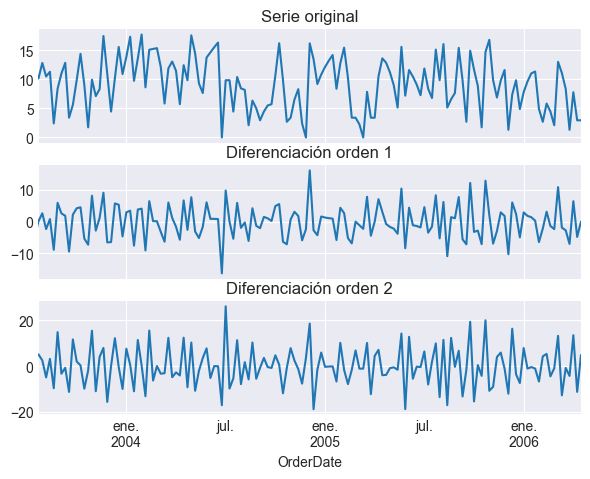

In [135]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = df_sales_a['TotalQuantitySold'].diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_sales_a['TotalQuantitySold'])
kpss_result = kpss(df_sales_a['TotalQuantitySold'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(df_sales_a['TotalQuantitySold'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(df_sales_a['TotalQuantitySold'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
df_sales_a['TotalQuantitySold'].plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

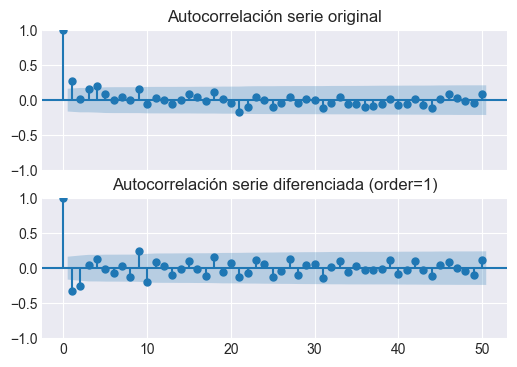

In [136]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(df_sales_a['TotalQuantitySold'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

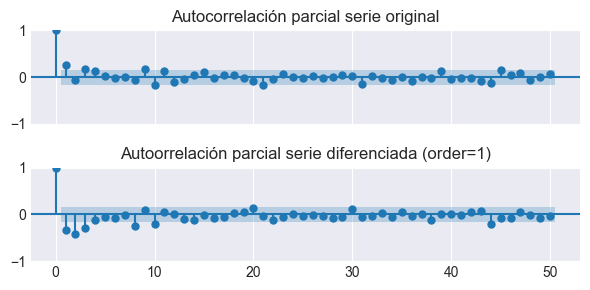

In [137]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(df_sales_a['TotalQuantitySold'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

In [138]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = train_data, order = (1, 0, 0), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                    TotalQuantitySold   No. Observations:                  116
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -311.471
Date:                             sá., 22 feb. 2025   AIC                            630.942
Time:                                      19:16:10   BIC                            641.520
Sample:                                  07-14-2003   HQIC                           635.227
                                       - 09-26-2005                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3293      0.094      3.520      0.000       0.146       0.513
ar.S.L12      -0.0841      0.147     -0.572      0.567      -0.372       0.204
ma.S.L12      -0.9989     25.622     -0.039      0.969     -51.217      49.219
sigma2        17.6740    451.760      0.039      0.969    -867.760     903.108
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.91   Prob(JB):                         0.57
Heteroskedasticity (H):               1.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

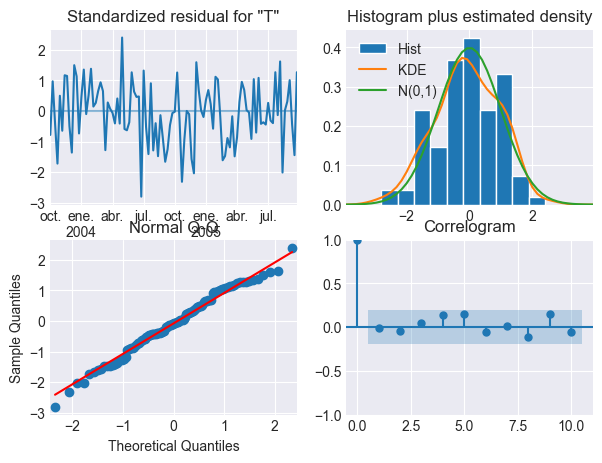

In [139]:
modelo_res.plot_diagnostics(figsize=(7,5))
plt.show()

In [140]:
modelo_res.get_prediction(start=len(train_data), end=len(train_data)+len(test_data)-1).summary_frame(alpha=0.05)

TotalQuantitySold       mean   mean_se  mean_ci_lower  mean_ci_upper
2005-10-03         11.101930  4.432971       2.413466      19.790394
2005-10-10          9.616784  4.667147       0.469344      18.764224
2005-10-17         10.516480  4.691591       1.321130      19.711829
2005-10-24          8.877658  4.691919      -0.318335      18.073651
2005-10-31          8.390951  4.670554      -0.763167      17.545069
2005-11-07         11.830174  4.670585       2.675996      20.984353
2005-11-14          8.447779  4.670588      -0.706406      17.601964
2005-11-21          7.339958  4.670589      -1.814228      16.494144
2005-11-28         10.766703  4.670589       1.612517      19.920889
2005-12-05         10.128150  4.670589       0.973965      19.282336
2005-12-12          8.956378  4.670589      -0.197807      18.110564
2005-12-19         11.545935  4.670589       2.391749      20.700120
2005-12-26          9.842778  4.671227       0.687342      18.998215
2006-01-02          9.039463  4.671273      -0.116065      18.194990
2006-01-09         10.792097  4.671067       1.636974      19.947220
2006-01-16          8.922798  4.669093      -0.228456      18.074051
2006-01-23          9.024785  4.650845      -0.090703      18.140273
2006-01-30         11.263912  4.650845       2.148424      20.379400
2006-02-06          8.288324  4.650845      -0.827164      17.403812
2006-02-13          7.365299  4.650845      -1.750189      16.480787
2006-02-20         11.157906  4.650845       2.042418      20.273394
2006-02-27         10.104842  4.650845       0.989354      19.220330
2006-03-06          8.429838  4.650845      -0.685650      17.545326
2006-03-13         11.830815  4.650844       2.715328      20.946303
2006-03-20          9.948702  4.671967       0.791814      19.105589
2006-03-27          9.088029  4.674229      -0.073292      18.249350
2006-04-03         10.768911  4.674260       1.607530      19.930291
2006-04-10          8.919000  4.672283      -0.238505      18.076506
2006-04-17          8.971464  4.653766      -0.149751      18.092678

In [141]:

# Realizar predicciones con intervalos de confianza
predicciones = modelo_res.get_prediction(start=len(train_data), end=len(train_data) + len(test_data) - 1)
predicciones_summary = predicciones.summary_frame(alpha=0.05)

# Extraer predicciones, intervalos inferior y superior
predicted_mean = predicciones_summary['mean']
predicted_ci_lower = predicciones_summary['mean_ci_lower']
predicted_ci_upper = predicciones_summary['mean_ci_upper']

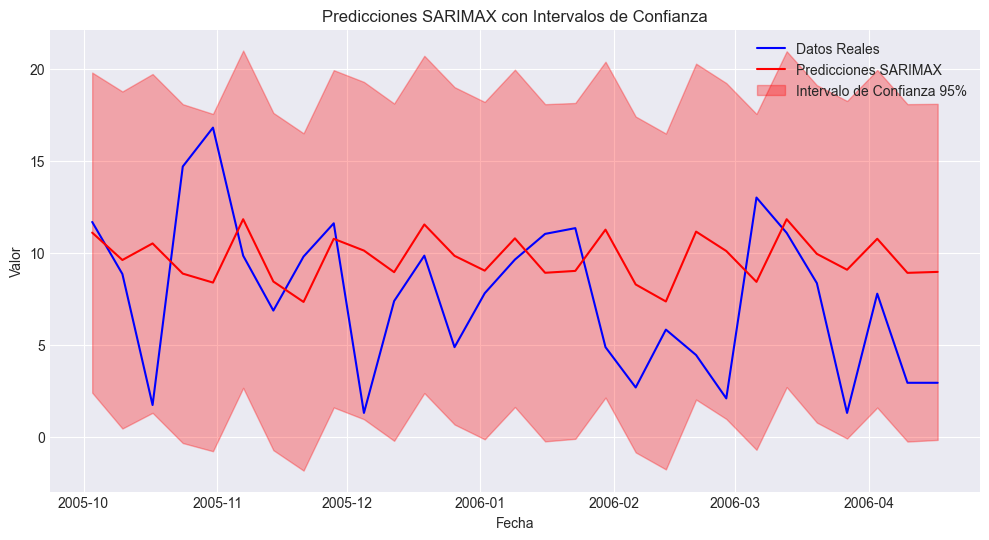

In [142]:
# Graficar las predicciones y los intervalos de confianza
plt.figure(figsize=(12, 6))

# Graficar los datos reales de prueba
plt.plot(test_data.index, test_data, label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(test_data.index, predicted_mean, label='Predicciones SARIMAX', color='red')

# Graficar los intervalos de confianza
plt.fill_between(test_data.index, predicted_ci_lower, predicted_ci_upper, color='red', alpha=0.3, label='Intervalo de Confianza 95%')

# Configurar las etiquetas y el título
plt.title('Predicciones SARIMAX con Intervalos de Confianza')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.show()



In [143]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(test_data)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

2005-10-03    11.101930
2005-10-10     9.616784
2005-10-17    10.516480
2005-10-24     8.877658
Freq: W-MON, Name: predicciones_statsmodels, dtype: float64

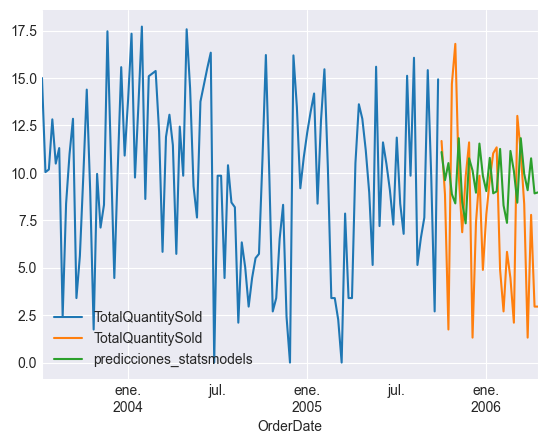

In [144]:
train_data.plot()
test_data.plot()
predicciones_statsmodels.plot()
plt.legend()
plt.show()

In [150]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = sm.tsa.SARIMAX(train_data, order=(2, 0, 1), seasonal_order=(1, 1, 1, 12))
results = modelo.fit()

warnings.filterwarnings("default")

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [149]:
modelo.param_terms

['ar', 'ma', 'seasonal_ar', 'seasonal_ma', 'variance']

In [ ]:
results.aic, results.aicc,results.bse, results.bic, results.conf_int()

(np.float64(632.3879142037297),
 np.float64(633.2538935851729),
 np.float64(648.254259598578),
                      0             1
 ar.L1        -0.840316     -0.351013
 ar.L2         0.030925      0.482681
 ma.L1        -3.605526      5.602805
 ar.S.L12     -0.365386      0.236737
 ma.S.L12  -4861.304664   4859.304688
 sigma2   -80942.800994  80976.118322)

In [155]:
pred_train = results.predict(start=0, end=len(train_data)-1)
pred_future = results.forecast(steps=len(test_data))
print(pred_future)


2005-10-03    11.112646
2005-10-10     9.366608
2005-10-17    10.662453
2005-10-24     8.727719
2005-10-31     8.626414
2005-11-07    11.622210
2005-11-14     8.477319
2005-11-21     7.296170
2005-11-28    10.914153
2005-12-05    10.071764
2005-12-12     8.870517
2005-12-19    11.556789
2005-12-26     9.915818
2006-01-02     8.992737
2006-01-09    10.810891
2006-01-16     8.829025
2006-01-23     9.052376
2006-01-30    11.244561
2006-02-06     8.317761
2006-02-13     7.350569
2006-02-20    11.175485
2006-02-27    10.082719
2006-03-06     8.451182
2006-03-13    11.793633
2006-03-20     9.975348
2006-03-27     9.032245
2006-04-03    10.787652
2006-04-10     8.834634
2006-04-17     9.014238
Freq: W-MON, Name: predicted_mean, dtype: float64


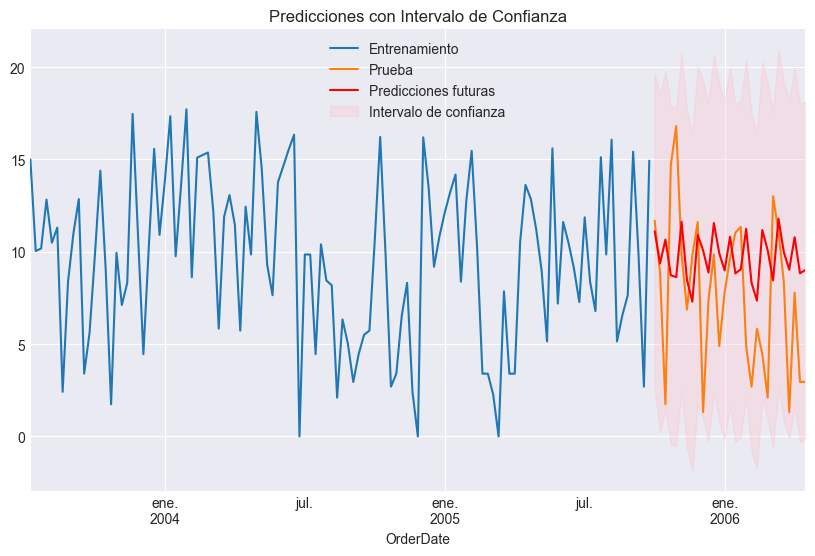

In [158]:
# Predicciones para el futuro con intervalos de confianza (por ejemplo, 95%)
steps = len(test_data)  # Número de pasos hacia el futuro que deseas predecir
forecast = results.get_forecast(steps=steps)
conf_int = forecast.conf_int(alpha=0.05)  # Intervalo de confianza del 95%

# Datos de entrenamiento y prueba
train_data.plot(label='Entrenamiento', figsize=(10, 6))
test_data.plot(label='Prueba')

# Predicciones futuras
pred_future = forecast.predicted_mean
pred_future.plot(label='Predicciones futuras', color='red')

# Intervalos de confianza (líneas de confianza superior e inferior)
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de confianza')

# Personalización del gráfico
plt.title("Predicciones con Intervalo de Confianza")
plt.legend()
plt.show()


In [161]:
df_prophet = df_sales_a.reset_index()
df_prophet = df_prophet.rename(columns={'OrderDate': 'ds', 'TotalQuantitySold': 'y'})
    

19:28:10 - cmdstanpy - INFO - Chain [1] start processing
19:28:10 - cmdstanpy - INFO - Chain [1] done processing


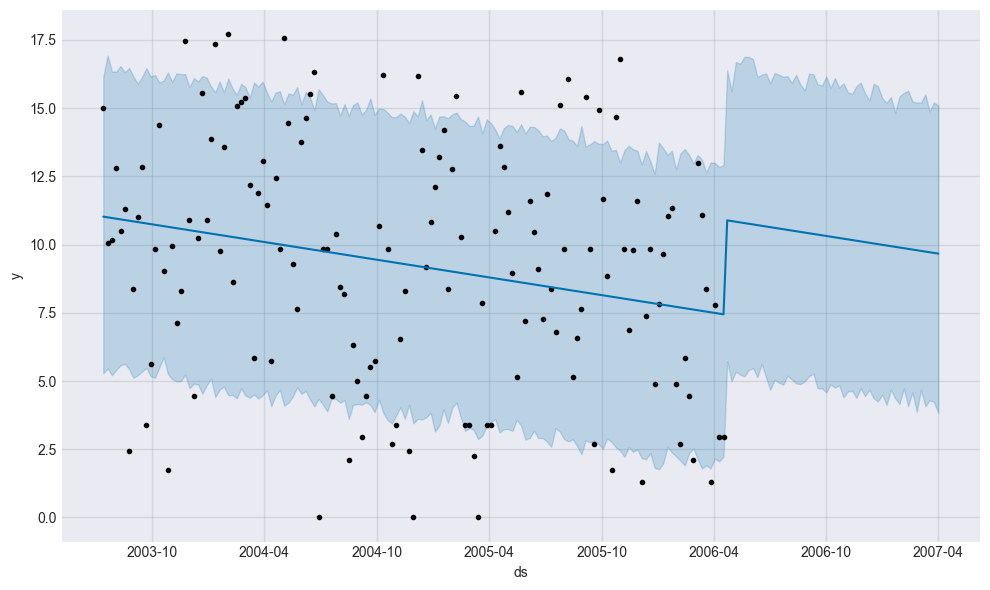

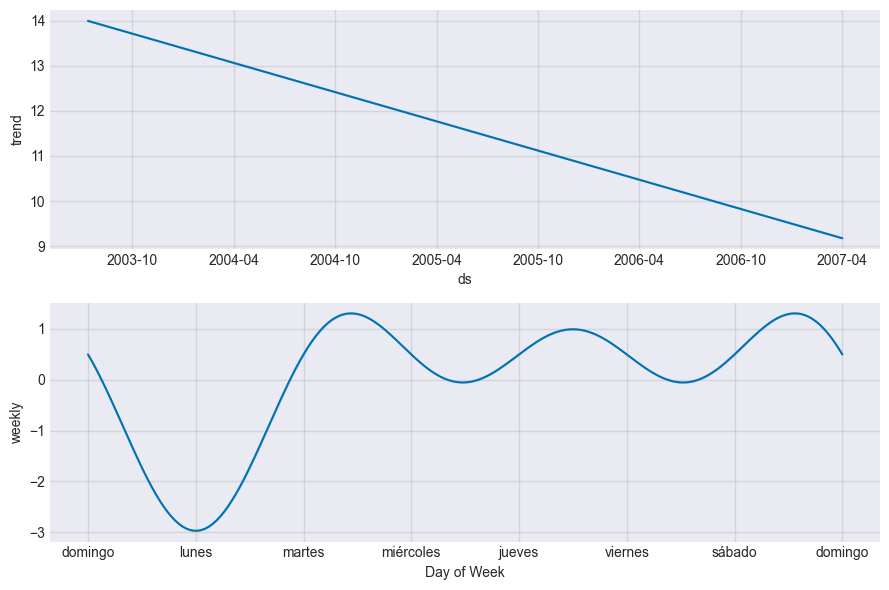

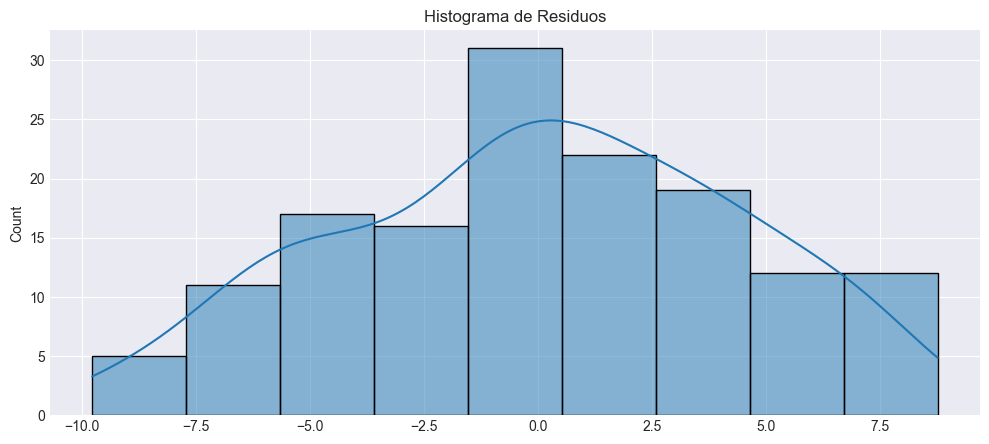

ValueError: The data contains non-finite values.

In [164]:
# --------------------------- CREACIÓN Y AJUSTE DEL MODELO CON PROPHET ---------------------------
modelo_prophet = Prophet(seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
modelo_prophet.fit(df_prophet)

# --------------------------- PREDICCIONES ---------------------------
# Crear un DataFrame con las fechas futuras para las que queremos hacer las predicciones
future = modelo_prophet.make_future_dataframe(periods=50, freq = 'W')

# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Visualizar las predicciones
modelo_prophet.plot(forecast)
plt.show()

# --------------------------- COMPONENTES DEL MODELO ---------------------------
modelo_prophet.plot_components(forecast)
plt.show()

# --------------------------- EVALUACIÓN DEL MODELO ---------------------------
# Evaluar los residuos
residuos = df_prophet['y'] - forecast['yhat'][:len(df)]

# Histograma de residuos
plt.figure(figsize=(12, 5))
sns.histplot(residuos, kde=True)
plt.title("Histograma de Residuos")
plt.show()

# QQ-Plot de residuos
import statsmodels.api as sm
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Residuos")
plt.show()

In [165]:
# Ajustar el modelo si es necesario
modelo_prophet = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,

)
modelo_prophet.fit(df_prophet)

19:28:53 - cmdstanpy - INFO - Chain [1] start processing
19:28:53 - cmdstanpy - INFO - Chain [1] done processing


In [167]:
# Predicciones
future = modelo_prophet.make_future_dataframe(periods=0, freq='W')
forecast = modelo_prophet.predict(future)

# Calcular los residuos (diferencia entre los valores reales y las predicciones)
residuos = df_prophet['y'] - forecast['yhat'][:len(df)]

# Calcular log-verosimilitud (aproximación)
log_likelihood = -0.5 * np.sum((residuos / np.std(residuos))**2)

# Número de parámetros del modelo (típicamente 4 para Prophet: 1 para tendencia, 1 para estacionalidad y 2 para los parámetros de error)
k = 4

# Número de observaciones
n = len(df)

# Calcular AIC y BIC
aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic}")
print(f"BIC: {bic}")

AIC: 153.01410569244234
BIC: 191.27124072142382


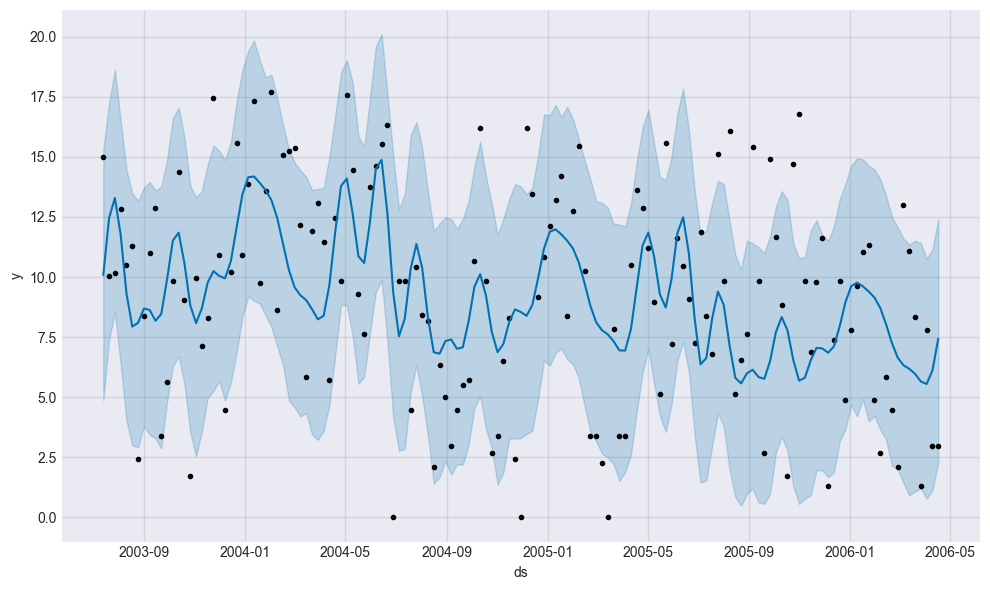

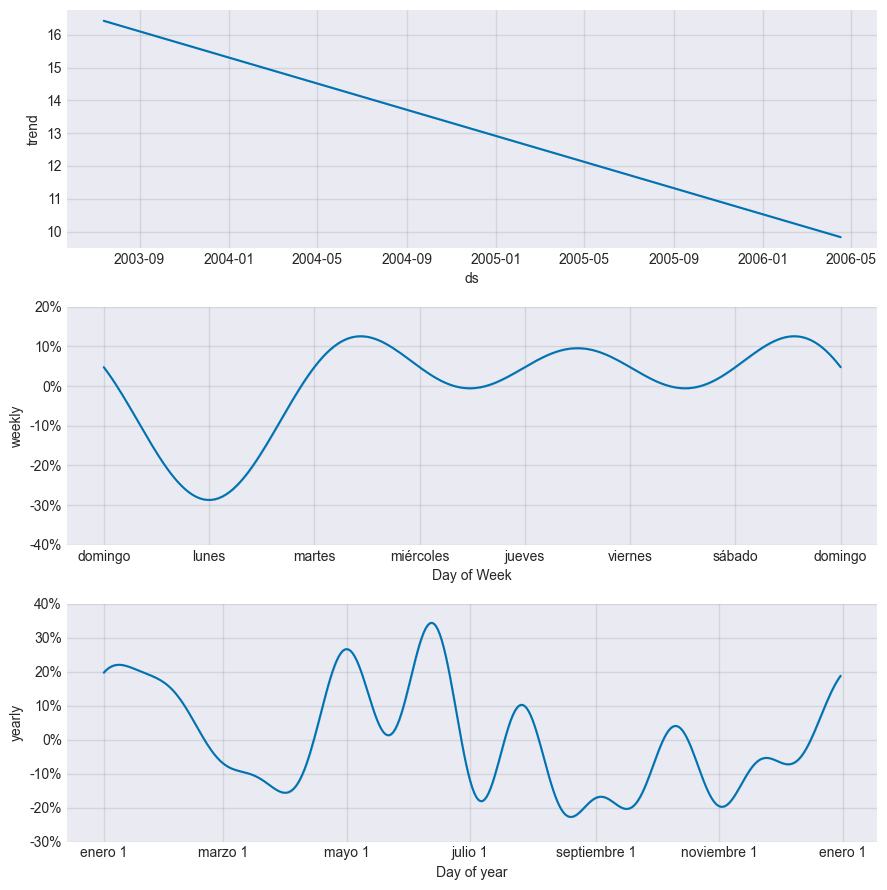

In [168]:
# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Visualizar las predicciones
modelo_prophet.plot(forecast)
plt.show()

# --------------------------- COMPONENTES DEL MODELO ---------------------------
modelo_prophet.plot_components(forecast)
plt.show()

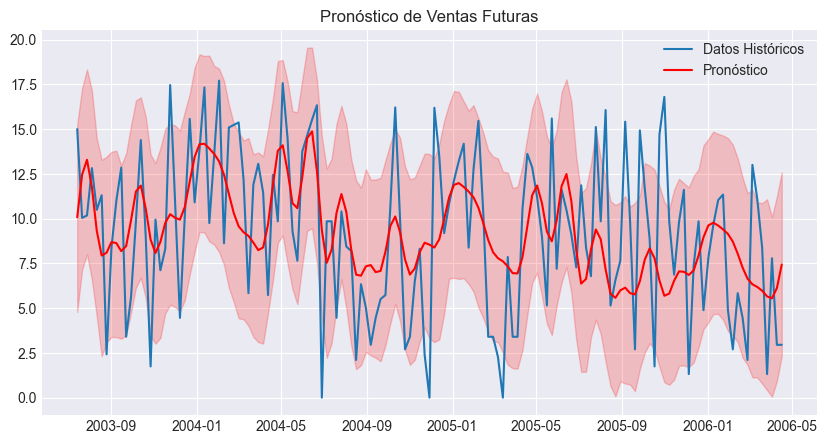

In [171]:

forecast_futuro = modelo_prophet.predict(future)
forecast_ci = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Visualización de las predicciones a futuro
plt.figure(figsize=(10,5))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Datos Históricos")
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label="Pronóstico", color='red')
plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Pronóstico de Ventas Futuras")
plt.show()

### Modelo de Suavización Exponencial (Baja Demanda - Clase C)

In [172]:
df_products_c = top_products[top_products['Classification'] == 'C']
df_products_c

ProductID ProductName ModelDescription     Category               Gender  \
71        4151     M-BX46E               BX       Boxers         Men's Briefs   
72        4152    XL-BX46E               BX       Boxers         Men's Briefs   
73        4160    M-BX46KE               BX       Boxers         Men's Briefs   
74        4161   XL-BX46KE               BX       Boxers         Men's Briefs   
75        4157    M-BX46SE               BX       Boxers         Men's Briefs   
76        4140   L-BX4668A               BX       Boxers         Men's Briefs   
77        4142  XL-BX4668A               BX       Boxers         Men's Briefs   
78        4146  M-BX4668CA               BX       Boxers         Men's Briefs   
79        4158   XL-BX46SE               BX       Boxers         Men's Briefs   
80        4245  M-BX4668KA               BX       Thongs      Women's Panties   
81        2638    M-TTB12S              TTB       Thongs      Women's Panties   
82        4384    M-TAB11P              TAB       Thongs      Women's Panties   
83        4143  L-BX4668SA               BX       Boxers         Men's Briefs   
84        4210   XXL-BX34C               BX       Boxers         Men's Briefs   
85        4181    XL-BX34F               BX       Boxers      Women's Panties   
86        4368    L-B4607S                B       Briefs      Women's Panties   
87        4376    S-B4628S                B       Briefs      Women's Panties   
88        4371  S-TIEE1405             TIEE       Thongs      Women's Panties   
89        4369     S-TB86P               TB       Thongs      Women's Panties   
90         308     L-S4675                S       Briefs      Women's Panties   
91        1108     S-BX34D               BX       Boxers         Men's Briefs   
92        2882     S-BP86D               BP       Briefs      Women's Panties   
93         176       L-C97                C       Briefs      Women's Panties   
94         399      M-C307                C       Briefs      Women's Panties   
95         551       M-K92                K       Briefs      Women's Panties   
96         767     XL-1771               AT  Undershirts    Men's Undershirts   
97        2759   M-TB46KXB               TB       Thongs      Women's Panties   
98        2832      1-AF33               AF       Briefs       Girls' Panties   
99         848     XL-K418                K       Briefs      Women's Panties   
100       2315    M-BX60C2               BX       Boxers         Men's Briefs   
101       3111    L-B46KDT                B       Briefs      Women's Panties   
102       3471   XL-BX77KA               BX       Boxers         Men's Briefs   
103       1598    XL-177S1               AT  Undershirts    Men's Undershirts   
104       2430  3XL-K4681S                K       Briefs      Women's Panties   
105       2571    S-B4606S                B       Briefs      Women's Panties   
106       1892  XL-BX46K3B               BX       Boxers         Men's Briefs   
107       2827      3-AL24               AL       Briefs       Girls' Panties   
108       3412      1-AR98               AR       Briefs       Girls' Panties   
109        643      S-3101             AT3K  Undershirts  Women's Undershirts   
110       1538      L-K404                K       Briefs      Women's Panties   

    ProductLine  Weight Size     PackSize             Status InventoryDate  \
71    Underwear      65    M  Single Unit      In Production    2006-03-15   
72    Underwear      85   XL  Single Unit      In Production    2006-03-15   
73    Underwear      75    M  Single Unit      In Production    2006-03-15   
74    Underwear      90   XL  Single Unit      In Production    2006-03-15   
75    Underwear      70    M  Single Unit      In Production    2006-03-15   
76    Underwear      75    L  Single Unit      In Production    2006-03-15   
77    Underwear      85   XL  Single Unit      In Production    2006-03-15   
78    Underwear      70    M  Single Unit      In Productio

In [175]:
df_class_c = df_products_c.merge(df_orders_details, on='ProductID')
df_class_c = df_class_c.merge(df_orders, on="OrderID")
df_class_c

ProductID ProductName ModelDescription Category           Gender  \
0         4151     M-BX46E               BX   Boxers     Men's Briefs   
1         4151     M-BX46E               BX   Boxers     Men's Briefs   
2         4152    XL-BX46E               BX   Boxers     Men's Briefs   
3         4160    M-BX46KE               BX   Boxers     Men's Briefs   
4         4161   XL-BX46KE               BX   Boxers     Men's Briefs   
..         ...         ...              ...      ...              ...   
252       1538      L-K404                K   Briefs  Women's Panties   
253       1538      L-K404                K   Briefs  Women's Panties   
254       1538      L-K404                K   Briefs  Women's Panties   
255       1538      L-K404                K   Briefs  Women's Panties   
256       1538      L-K404                K   Briefs  Women's Panties   

    ProductLine  Weight Size     PackSize             Status  ...  \
0     Underwear      65    M  Single Unit      In Production  ...   
1     Underwear      65    M  Single Unit      In Production  ...   
2     Underwear      85   XL  Single Unit      In Production  ...   
3     Underwear      75    M  Single Unit      In Production  ...   
4     Underwear      90   XL  Single Unit      In Production  ...   
..          ...     ...  ...          ...                ...  ...   
252   Underwear     420    L        Dozen  Out of Production  ...   
253   Underwear     420    L        Dozen  Out of Production  ...   
254   Underwear     420    L        Dozen  Out of Production  ...   
255   Underwear     420    L        Dozen  Out of Production  ...   
256   Underwear     420    L        Dozen  Out of Production  ...   

    total_price_y  CustomerID EmployeeID  ShippingMethodID   OrderDate  \
0             9.5         245         16                 1  2006-04-01   
1           184.0         231         14                 1  2006-04-01   
2           228.0         231         14                 1  2006-04-01   
3           204.0         231         14                 1  2006-04-01   
4           240.0         231         14                 1  2006-04-01   
..            ...         ...        ...               ...         ...   
252           9.8          21          6                 1  2004-05-07   
253          49.0           5          6                 1  2004-05-20   
254          17.1         108          6                 1  2004-06-10   
255          14.7          21          6                 1  2004-06-11   
256          24.5           5          6                 1  2004-06-24   

       ShipDate  FreightCharge  DeliveryTime OrderYear  OrderMonth  
0    2006-04-01           31.0             0      2006           4  
1    2006-04-01            0.0             0      2006           4  
2    2006-04-01            0.0             0      2006           4  
3    2006-04-01            0.0             0      2006           4  
4    2006-04-01            0.0             0      2006           4  
..          ...            ...           ...       ...         ...  
252  2004-05-07            0.0             0      2004           5  
253  2004-05-20           28.0             0      2004           5  
254  2004-06-10           28.0             0      2004           6  
255  2004-06-11            0.0             0      2004           6  
256  2004-06-24           28.0             0      2004           6  

[257 rows x 33 columns]